In [61]:
import os
from datetime import datetime
import numpy as np
import pandas as pd
from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras.models import load_model
from matplotlib import pyplot as plt
%matplotlib inline

from spacepy import pycdf

# Configure Matplotlib

Choose a matplotlib style sheet to match your browser theme (dark or light)

Increase the figure size to match the notebook width.

Set the graph colour variables.

In [62]:
#style_sheet = 'dark_background' # dark theme
style_sheet = 'default'         # light theme
plt.style.use(style_sheet)

plt.rcParams['figure.figsize'] = [12, 8]
plt.rcParams['figure.dpi'] = 200

dsc_colour = 'green'
wnd_colour = 'magenta'
anl_colour = 'red'

# WIND magnetic field observation data location
The magnetic field measurement data from WIND is our input or X. In this case it will also be our output or Y
We will use just 1 day of observations to keep things simple.

In [63]:
WND_MFI_DIR = 'data/raw/WIND/mfi/2022'
wnd_mfi_sample = 'wi_h2_mfi_20220514_v04.cdf'
xwnd_filename = os.path.join(WND_MFI_DIR, wnd_mfi_sample)
cdf_xwnd = pycdf.CDF(xwnd_filename)
wnd_B = cdf_xwnd['BGSE']
wnd_t = cdf_xwnd['Time_PB5']
print("WIND MFI B shape:",wnd_B.shape)
print("WIND MFI Time_PB5 shape:",wnd_t.shape)

WIND MFI B shape: (935602, 3)
WIND MFI Time_PB5 shape: (935602, 3)


# DSCOVR magnetic field observation data location
The magnetic field measurement data from DSCOVR is the data we will use our model to run inference on.
Again, we will use the same day of observations as WIND to keep things simple and well aligned.

In [64]:
DSC_MFI_DIR = 'data/raw/DSCVR/mfi/2022'
wnd_mfi_sample = 'wi_h2_mfi_20220514_v04.cdf'
xdsc_filename = os.path.join(DSC_MFI_DIR,'dscovr_h0_mag_20220514_v01.cdf')
cdf_xdsc = pycdf.CDF(xdsc_filename)
dsc_B = cdf_xdsc['B1GSE']
dsc_t = cdf_xdsc['Time1_PB5']
print("DSCOVR MFI B shape:",dsc_B.shape)
print("DSCOVR MFI Time1_PB5 shape:",dsc_t.shape)

DSCOVR MFI B shape: (86400, 3)
DSCOVR MFI Time1_PB5 shape: (86400, 3)


# Time Steps
We use a simple linear equation to map DSCVOR time steps to corresponding WIND time steps. 
This was determined empirically by analyzing WIND and DSCOVR magnetic field data files.

In [65]:
start = 0
stop = 86400
time_steps = np.linspace(start, stop, num=stop-start, endpoint=False)
wnd_t_ix = np.rint(time_steps * 10.828726851851853 + 5).astype(int)
print(wnd_t_ix[0:10])

[  5  16  27  37  48  59  70  81  92 102]


# Plotting DSCOVR magnetic field vectors
We will plot each vector (Bx, By, Bz) stacked. The x axis is in seconds from 0 (midnight) to 86399 (last second of the day)

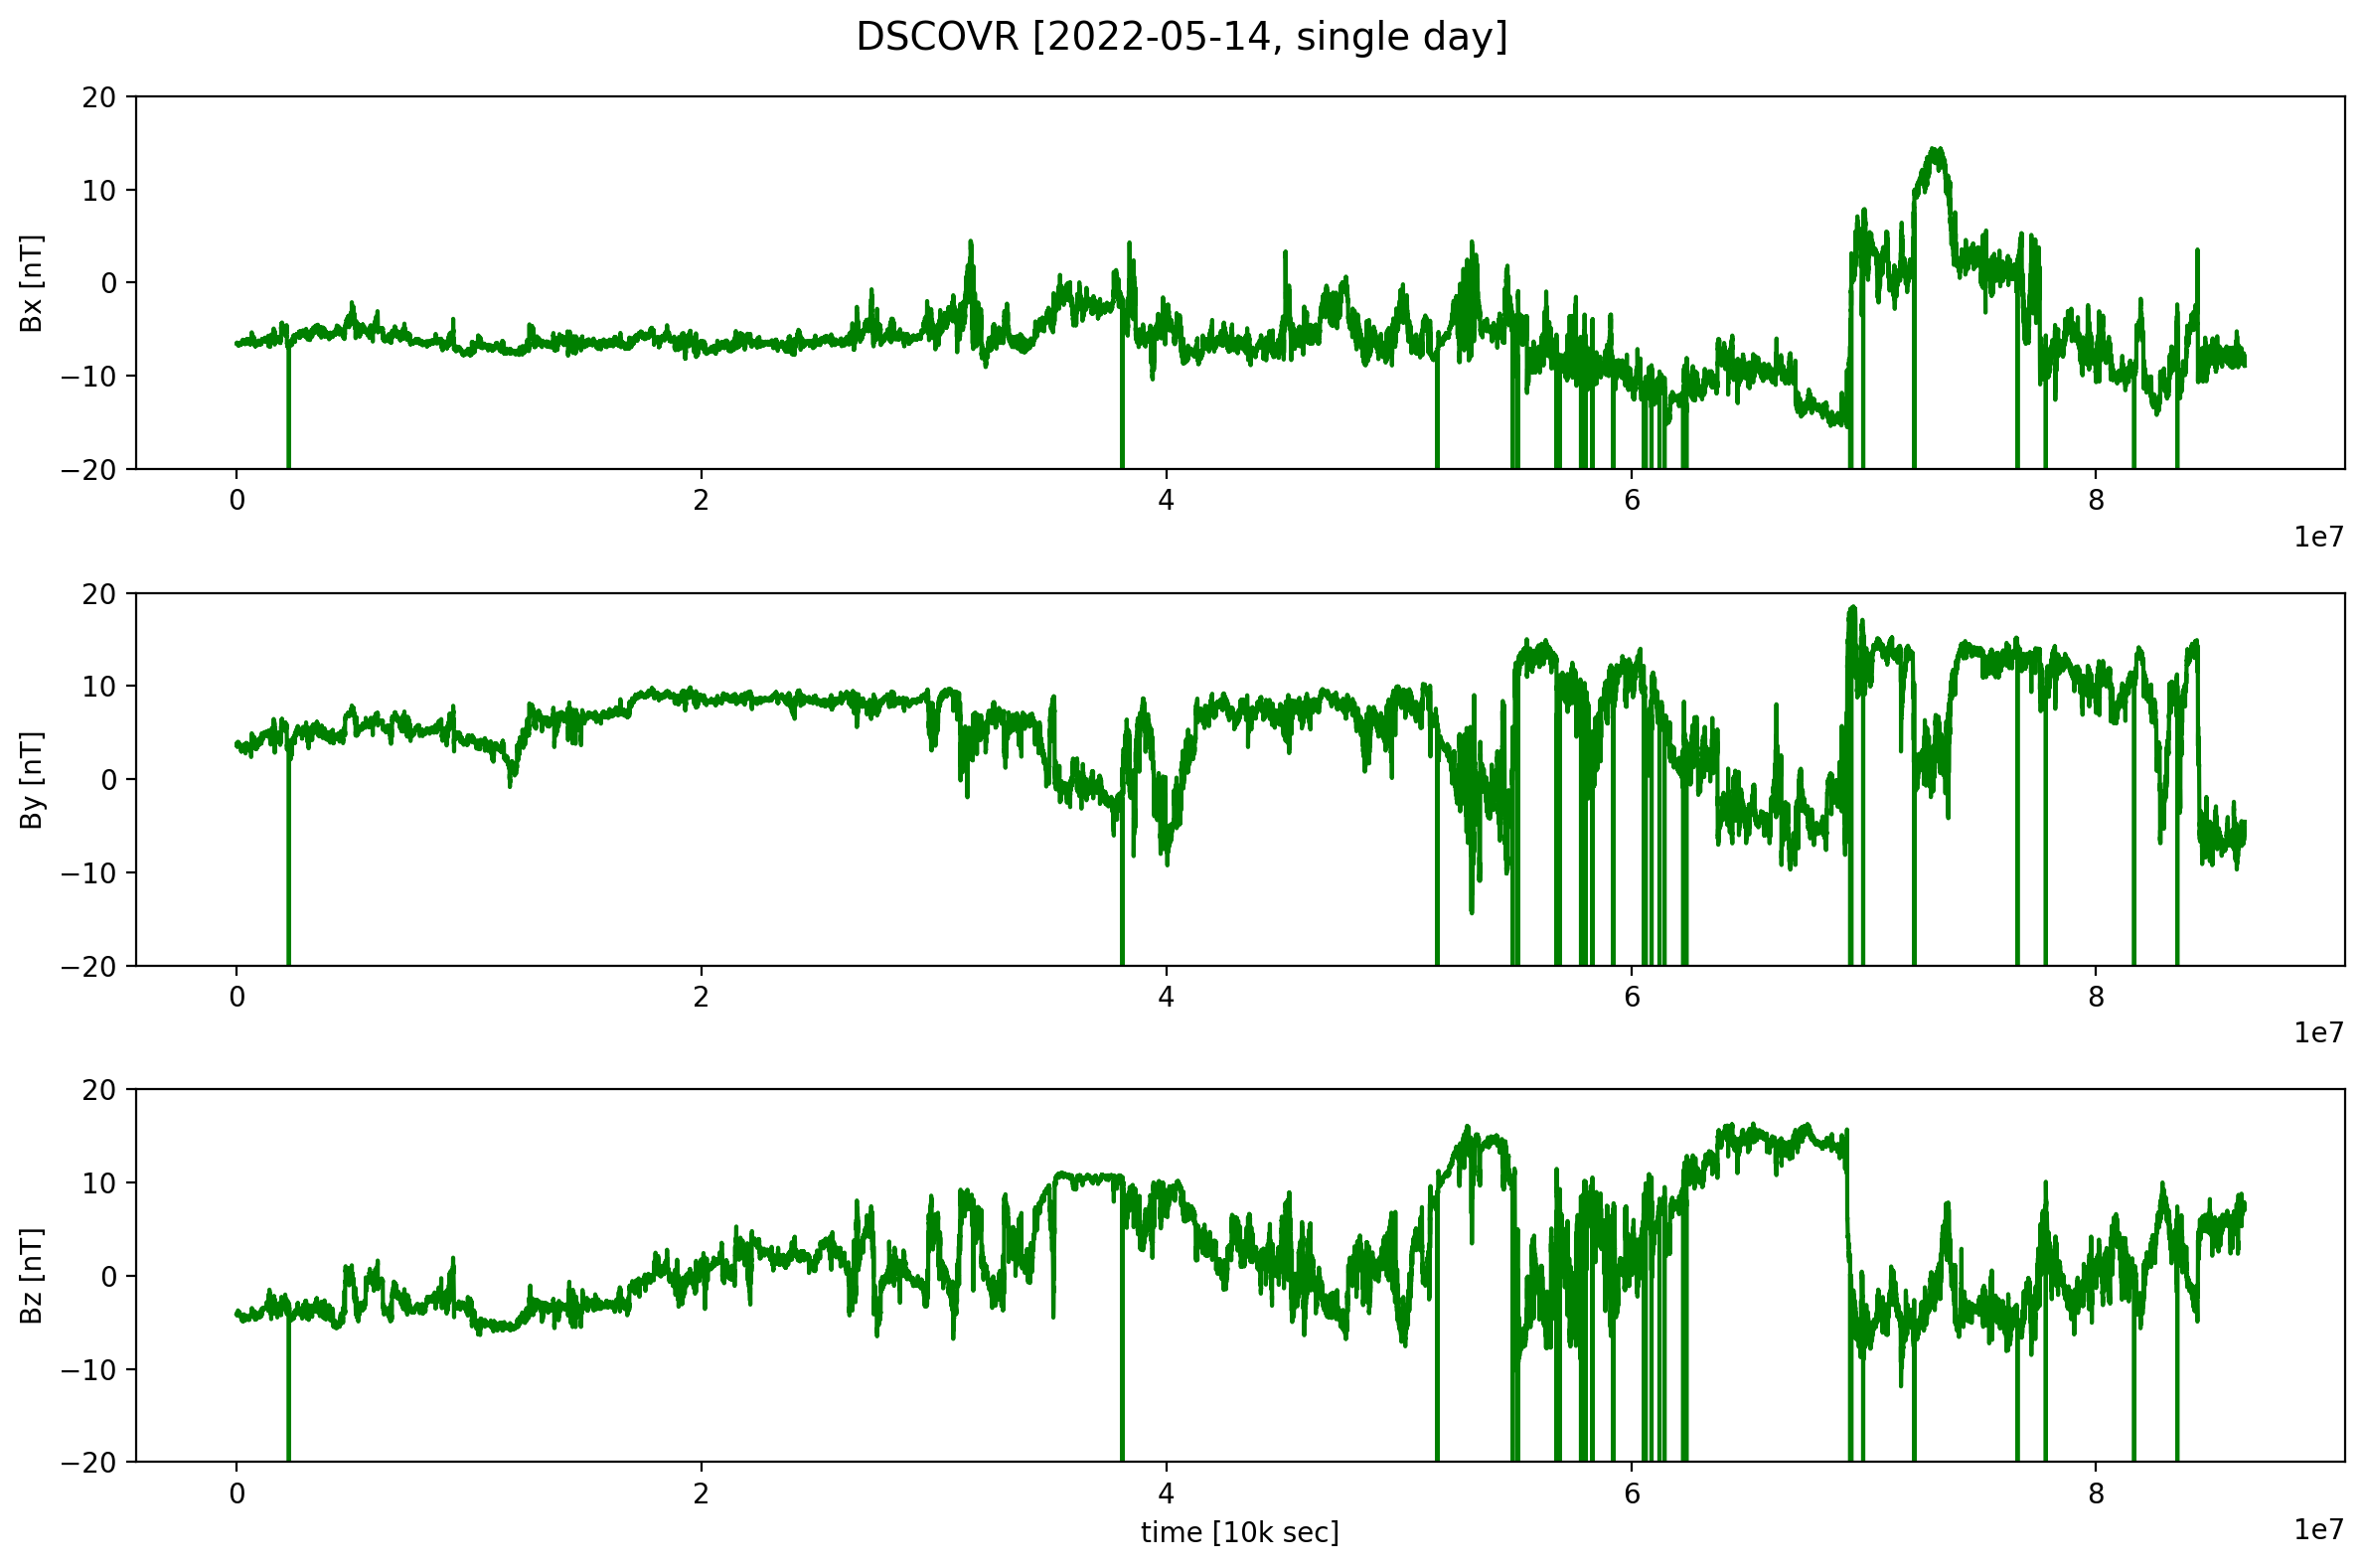

In [66]:
fig, axs = plt.subplots(3, 1)
title = 'DSCOVR [2022-05-14, single day]'
fig.suptitle(title, fontsize=14)

d_t = np.asarray(dsc_t[:,:])
d_b = np.asarray(dsc_B[:,:])

d_bx, = axs[0].plot(dsc_t[:,2], dsc_B[:,0], color=dsc_colour, label='Bx')
d_by, = axs[1].plot(dsc_t[:,2], dsc_B[:,1], color=dsc_colour, label='By')
d_bz, = axs[2].plot(dsc_t[:,2], dsc_B[:,2], color=dsc_colour, label='Bz')

axs[0].set(ylabel='Bx [nT]')
axs[1].set(ylabel='By [nT]')
axs[2].set(ylabel='Bz [nT]')

axs[0].set(ylim=(-20,20))
axs[1].set(ylim=(-20,20))
axs[2].set(ylim=(-20,20))

axs[2].set(xlabel='time [10k sec]')

plt.tight_layout()

# Plotting WIND magnetic field vectors
We will plot each vector (Bx, By, Bz) stacked. The x axis is in seconds from 0 (midnight) to 86399 (last second of the day).
Note the correlation between DSCOVR and WIND. It isn't exact but it is clearly correlated.

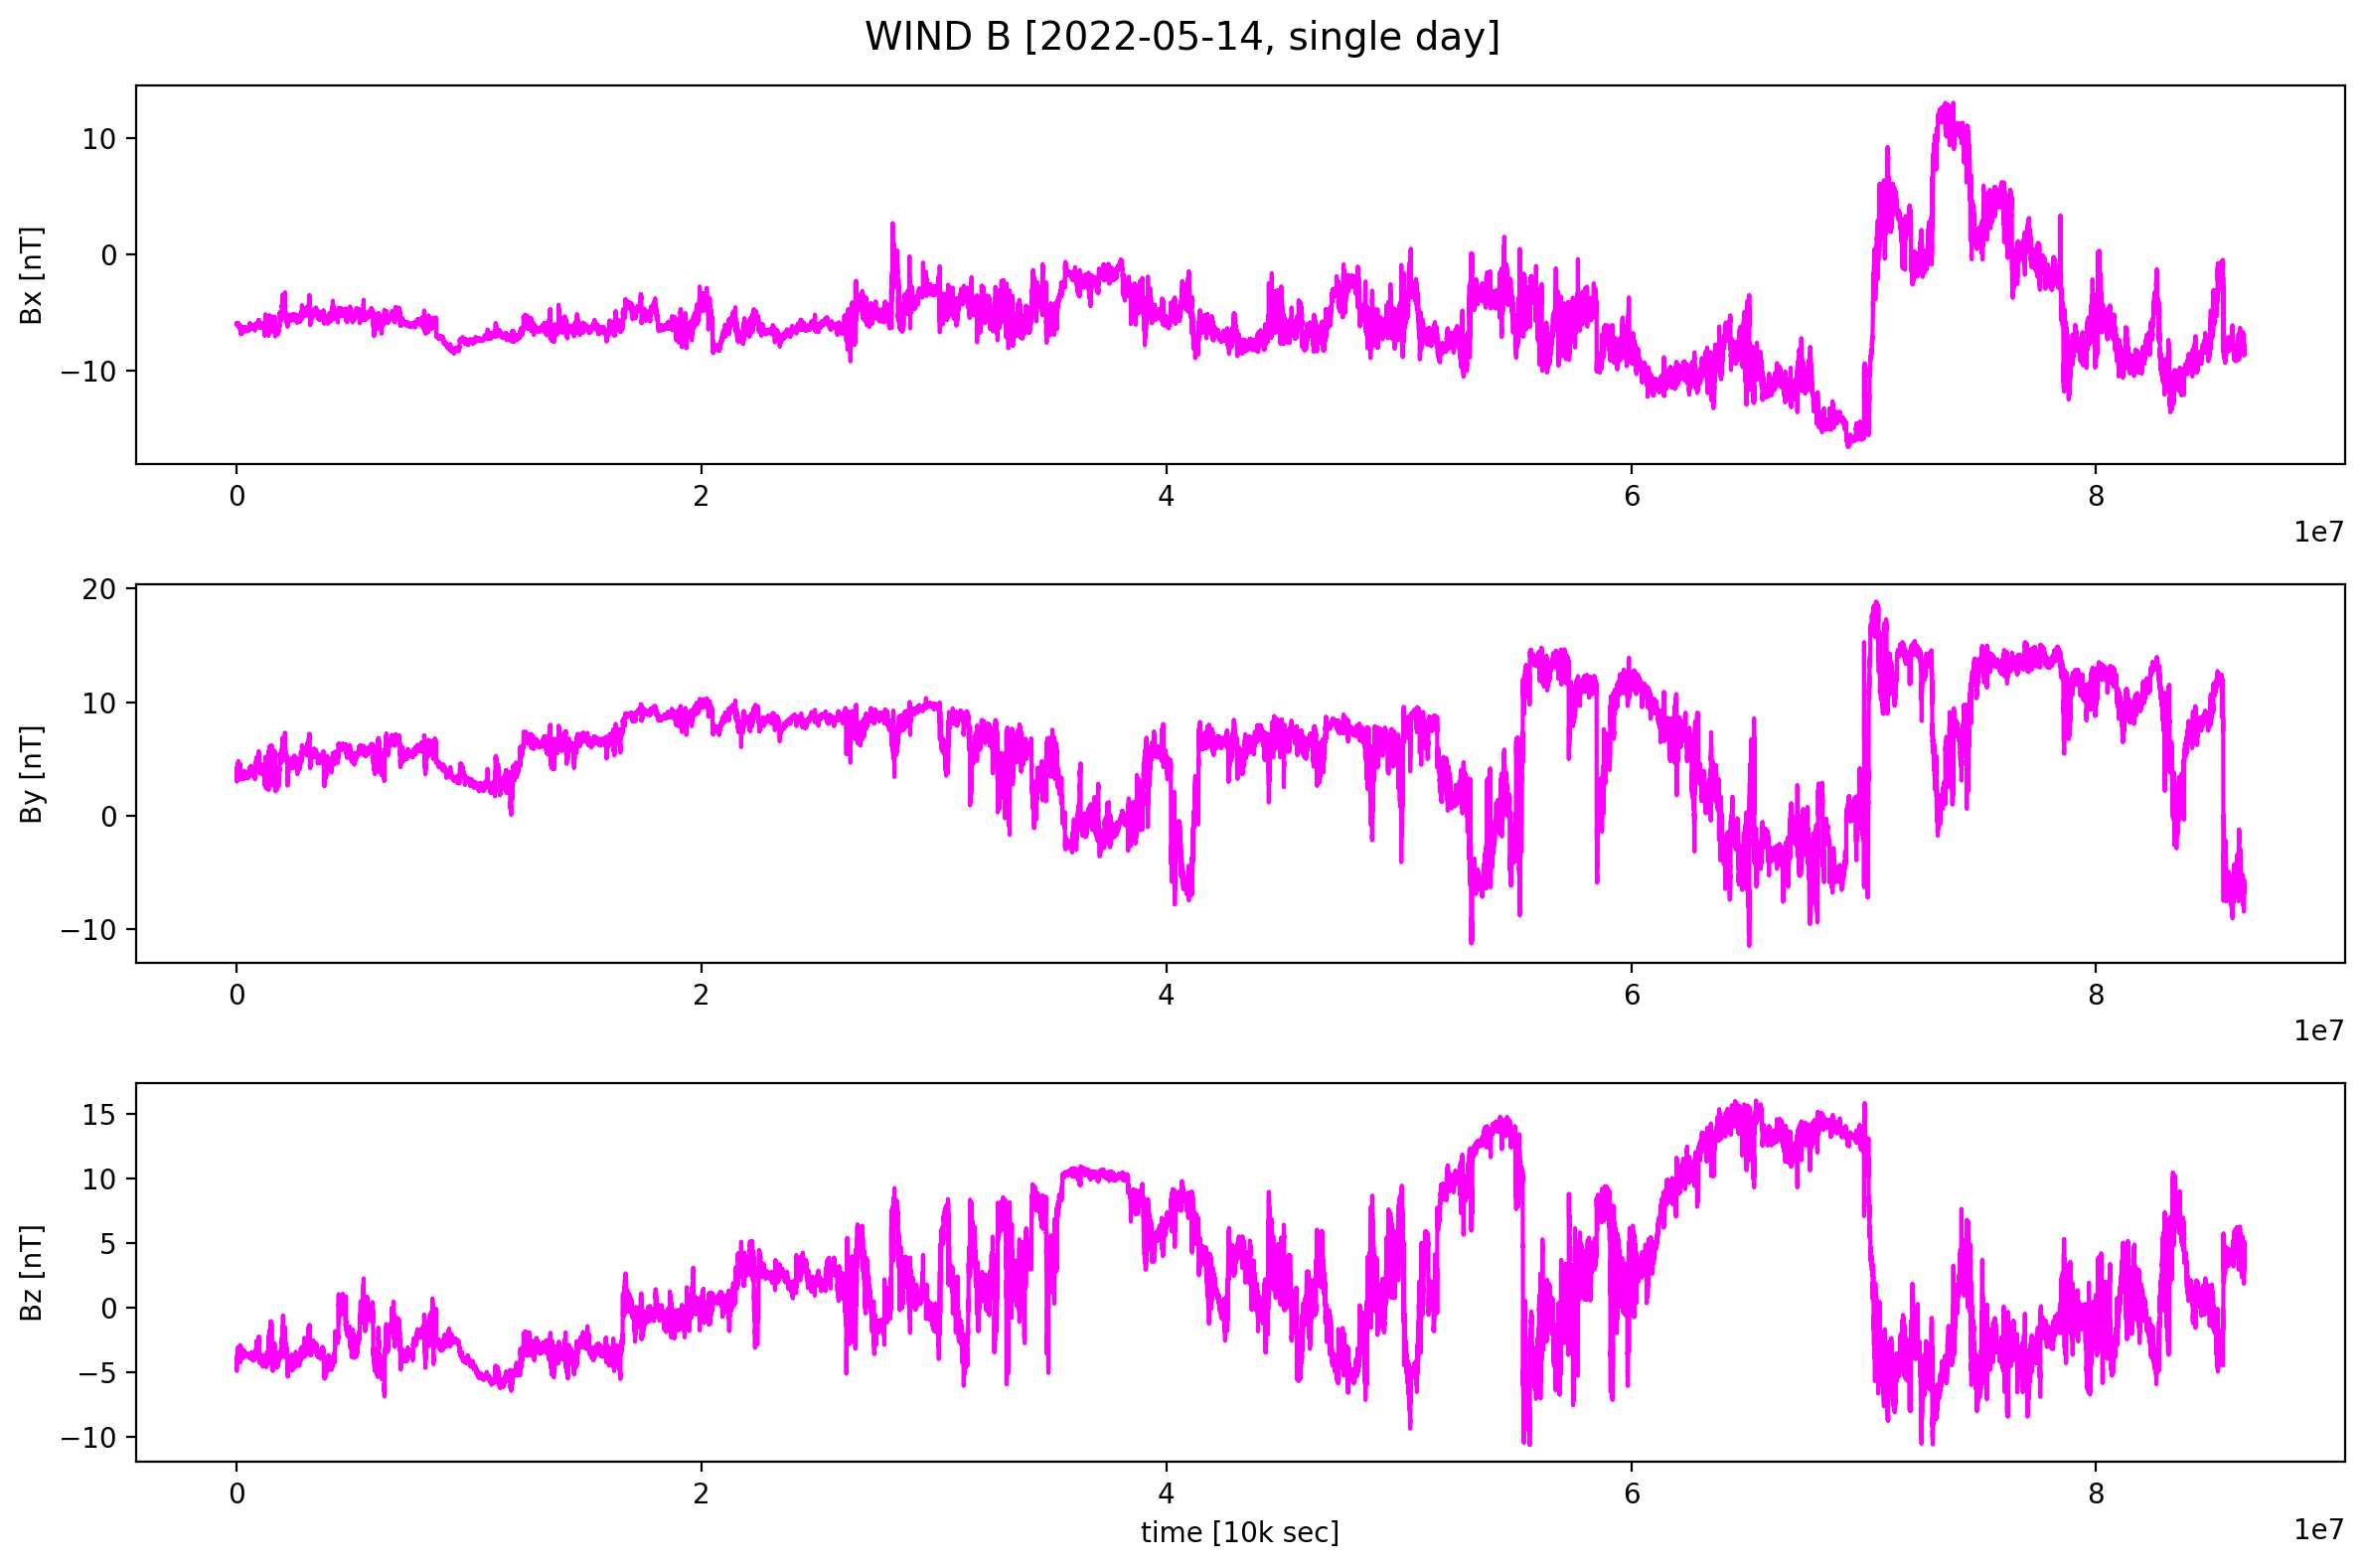

In [67]:
fig, axs = plt.subplots(3, 1)
title = 'WIND B [2022-05-14, single day]'
fig.suptitle(title, fontsize=14)

w_t = np.asarray(wnd_t[:,:])
w_b = np.asarray(wnd_B[:,:])

w_bx, = axs[0].plot(w_t[wnd_t_ix,2], w_b[wnd_t_ix,0], color=wnd_colour, label='Bx')
w_by, = axs[1].plot(w_t[wnd_t_ix,2], w_b[wnd_t_ix,1], color=wnd_colour, label='By')
w_bz, = axs[2].plot(w_t[wnd_t_ix,2], w_b[wnd_t_ix,2], color=wnd_colour, label='Bz')

axs[0].set(ylabel='Bx [nT]')
axs[1].set(ylabel='By [nT]')
axs[2].set(ylabel='Bz [nT]')

#axs[0].set(ylim=(-20,20))
#axs[1].set(ylim=(-20,20))
#axs[2].set(ylim=(-20,20))

axs[2].set(xlabel='time [10k sec]')

plt.tight_layout()

# Normalize the data before training

In [68]:
# Normalize and save the mean and std we get,
# for normalizing test data.
training_mean = w_b.mean()
training_std = w_b.std()
df_training_value = (w_b[wnd_t_ix]  - training_mean) / training_std
print("Number of training samples:", len(df_training_value))

Number of training samples: 86400


# Time Conversion functions

Let's define some helper functions to convert some time formats into human readable time.
Shout out to [GeeksForGeeks](https://www.geeksforgeeks.org/python-program-to-convert-seconds-into-hours-minutes-and-seconds/) for a nifty date conversion in Python.

In [69]:
def time_from_seconds(seconds):
  seconds = seconds % (24 * 3600)
  hour = seconds // 3600
  seconds %= 3600
  minutes = seconds // 60
  seconds %= 60
     
  return "%d:%02d:%02d" % (hour, minutes, seconds)

def time_from_doy(doy):
  part, whole = np.modf(doy)
  seconds = part * 86400
     
  return time_from_seconds(seconds)

def date_from_yeardoy(year, doy):
  part, whole = np.modf(doy)
  datestr = "%4d-%03.0f"%(year, whole)
  # converting to date
  unix_dt = datetime.strptime(datestr, "%Y-%j")
  res = unix_dt.strftime("%Y-%m-%d")
  return res

In [70]:
timestamp_str = "%s %s" %(date_from_yeardoy(2020,339.04167),time_from_doy(339.04167))
print("2020 339.04167 days:", timestamp_str)

2020 339.04167 days: 2020-12-04 1:00:00


# How many seconds since the year when WIND was launched?

In [71]:
date_1 = '1994-01-01 00:00:00'
date_2 = timestamp_str
date_format_str = '%Y-%m-%d %H:%M:%S'
start = datetime.strptime(date_1, date_format_str)
end =   datetime.strptime(date_2, date_format_str)
# Get the interval between two datetimes as timedelta object
diff = end - start
print('Difference between two datetimes in seconds:')
print(diff.total_seconds())

Difference between two datetimes in seconds:
849661200.0


# Parse time series data into sequences
We arbitrarily chose 5 minute sequences (300 seconds) for our model.
Here is a helper function (lifted from the Keras example) to generate sequences.
We call it on the training set to produce "x_train", our input to the model.

In [72]:
TIME_STEPS = 300

# Generated training sequences for use in the model.
def create_sequences(values, time_steps=TIME_STEPS):
    output = []
    for i in range(len(values) - time_steps + 1):
        output.append(values[i : (i + time_steps)])
    return np.stack(output)

x_train = create_sequences(df_training_value)
print("Training input shape: ", x_train.shape)

Training input shape:  (86101, 300, 3)


# Autoencoder Model Architecture
We use Keras to construct an autoencoder with 5 layers.
The first 2 layers are the encoder.
The next 2 layers are the decoder.
The last layer generates the final output with matching dimension to the input.
We use the Adam optimizer.

In [73]:
model = keras.Sequential(
    [
        layers.Input(shape=(x_train.shape[1], x_train.shape[2])),
        layers.Conv1D(
            filters=32, kernel_size=7, padding="same", strides=2, activation="relu"
        ),
        #layers.Dropout(rate=0.2),
        layers.Conv1D(
            filters=16, kernel_size=7, padding="same", strides=2, activation="relu"
        ),
        layers.Conv1DTranspose(
            filters=16, kernel_size=7, padding="same", strides=2, activation="relu"
        ),
        #layers.Dropout(rate=0.2),
        layers.Conv1DTranspose(
            filters=32, kernel_size=7, padding="same", strides=2, activation="relu"
        ),
        layers.Conv1DTranspose(filters=3, kernel_size=7, padding="same"),
    ]
)
model.compile(optimizer=keras.optimizers.Adam(learning_rate=1e-3), loss="mse")
model.summary()

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv1d_2 (Conv1D)            (None, 150, 32)           704       
_________________________________________________________________
conv1d_3 (Conv1D)            (None, 75, 16)            3600      
_________________________________________________________________
conv1d_transpose_3 (Conv1DTr (None, 150, 16)           1808      
_________________________________________________________________
conv1d_transpose_4 (Conv1DTr (None, 300, 32)           3616      
_________________________________________________________________
conv1d_transpose_5 (Conv1DTr (None, 300, 3)            675       
Total params: 10,403
Trainable params: 10,403
Non-trainable params: 0
_________________________________________________________________


# Train the model
We train for 50 epochs with batch size of 256 and a validation split of 10%. 
We use early stopping with a patience of 5 and minimize validation loss. 
We use mean squared error (MSE) as the loss function.

In [24]:
history = model.fit(
    x_train,
    x_train,
    epochs=50,
    batch_size=256,
    validation_split=0.1,
    callbacks=[
        keras.callbacks.EarlyStopping(monitor="val_loss", patience=5, mode="min")
    ],
)

Epoch 1/50
303/303 [==============================] - 8s 27ms/step - loss: 0.0581 - val_loss: 0.0064
Epoch 2/50
303/303 [==============================] - 8s 26ms/step - loss: 0.0035 - val_loss: 0.0038
Epoch 3/50
303/303 [==============================] - 8s 26ms/step - loss: 0.0025 - val_loss: 0.0028
Epoch 4/50
303/303 [==============================] - 8s 26ms/step - loss: 0.0020 - val_loss: 0.0028
Epoch 5/50
303/303 [==============================] - 8s 26ms/step - loss: 0.0018 - val_loss: 0.0024
Epoch 6/50
303/303 [==============================] - 8s 26ms/step - loss: 0.0016 - val_loss: 0.0020
Epoch 7/50
303/303 [==============================] - 8s 26ms/step - loss: 0.0015 - val_loss: 0.0025
Epoch 8/50
303/303 [==============================] - 8s 26ms/step - loss: 0.0014 - val_loss: 0.0017
Epoch 9/50
303/303 [==============================] - 8s 26ms/step - loss: 0.0013 - val_loss: 0.0017
Epoch 10/50
303/303 [==============================] - 8s 26ms/step - loss: 0.0012 - val_lo

# Load/Save the model
Here we load our best model weights or save the model we just trained.

In [74]:
#model.save("aw_bs256_lr1e-3_do0_v1")
model=load_model("aw_bs256_lr1e-3_do0_v1")
#model.save("aw_bs256_lr1e-3_do0")
#model=load_model("aw_bs256_lr1e-3_do0")

# Plot training history
We plot the training loss and validation loss curves to monitor overfitting and convergence.

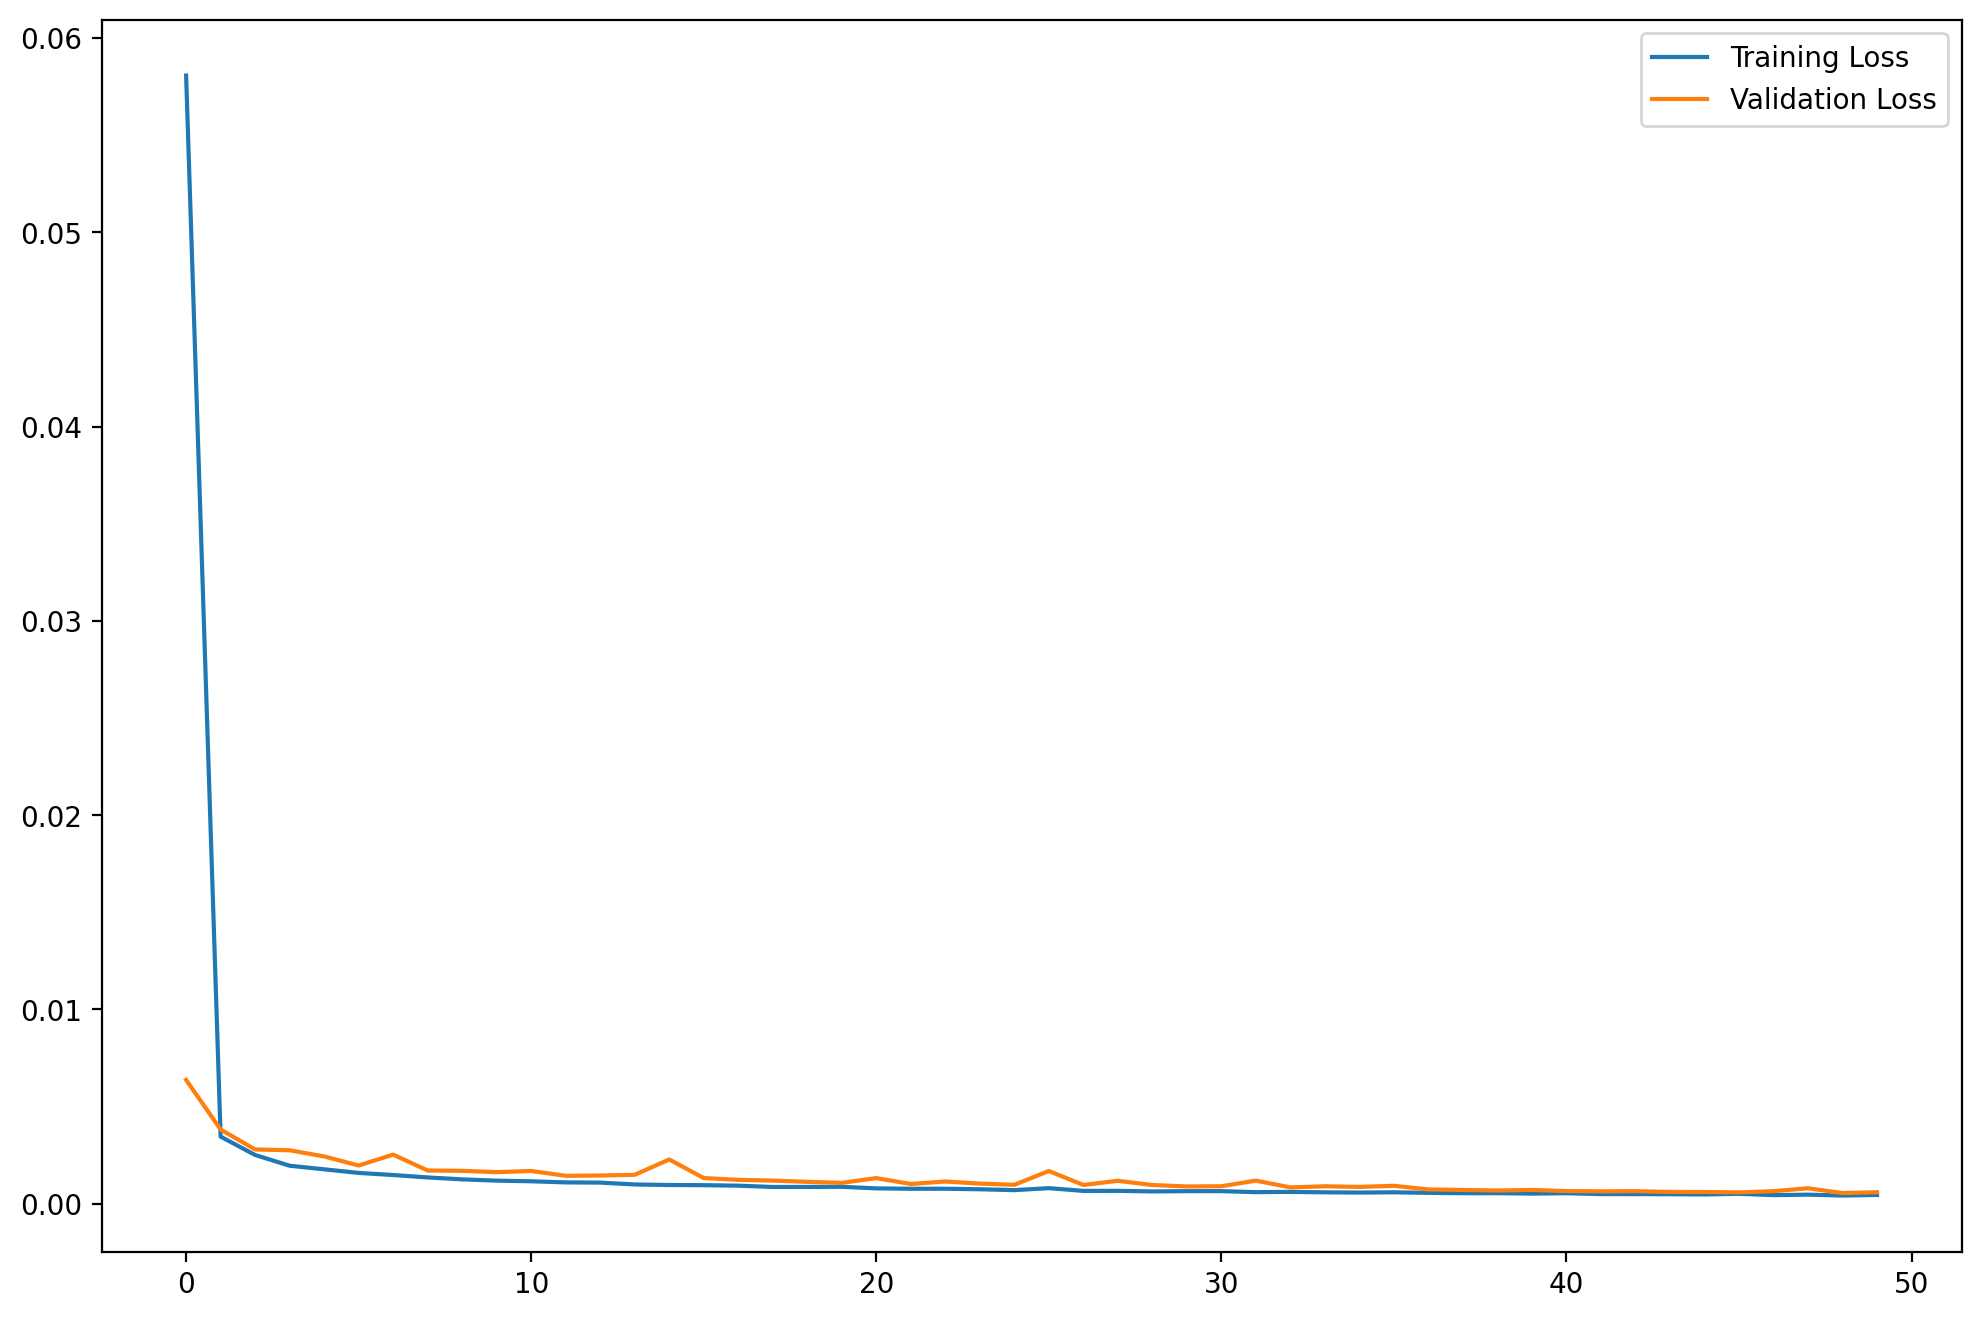

In [28]:
plt.plot(history.history["loss"], label="Training Loss")
plt.plot(history.history["val_loss"], label="Validation Loss")
plt.legend()
plt.show()

# Reconstruction Loss
Our autoencoder has learned to reproduce the input.
We evaluate the performance of our model by comparing the difference (absolute error) between the output and input.
To visualize the distribution over each magnetic field vector we plot a histogram of the mean absolute error of each sequence.
We set our anomaly threshold to the maximum value. We will use this later to detect anomalies.

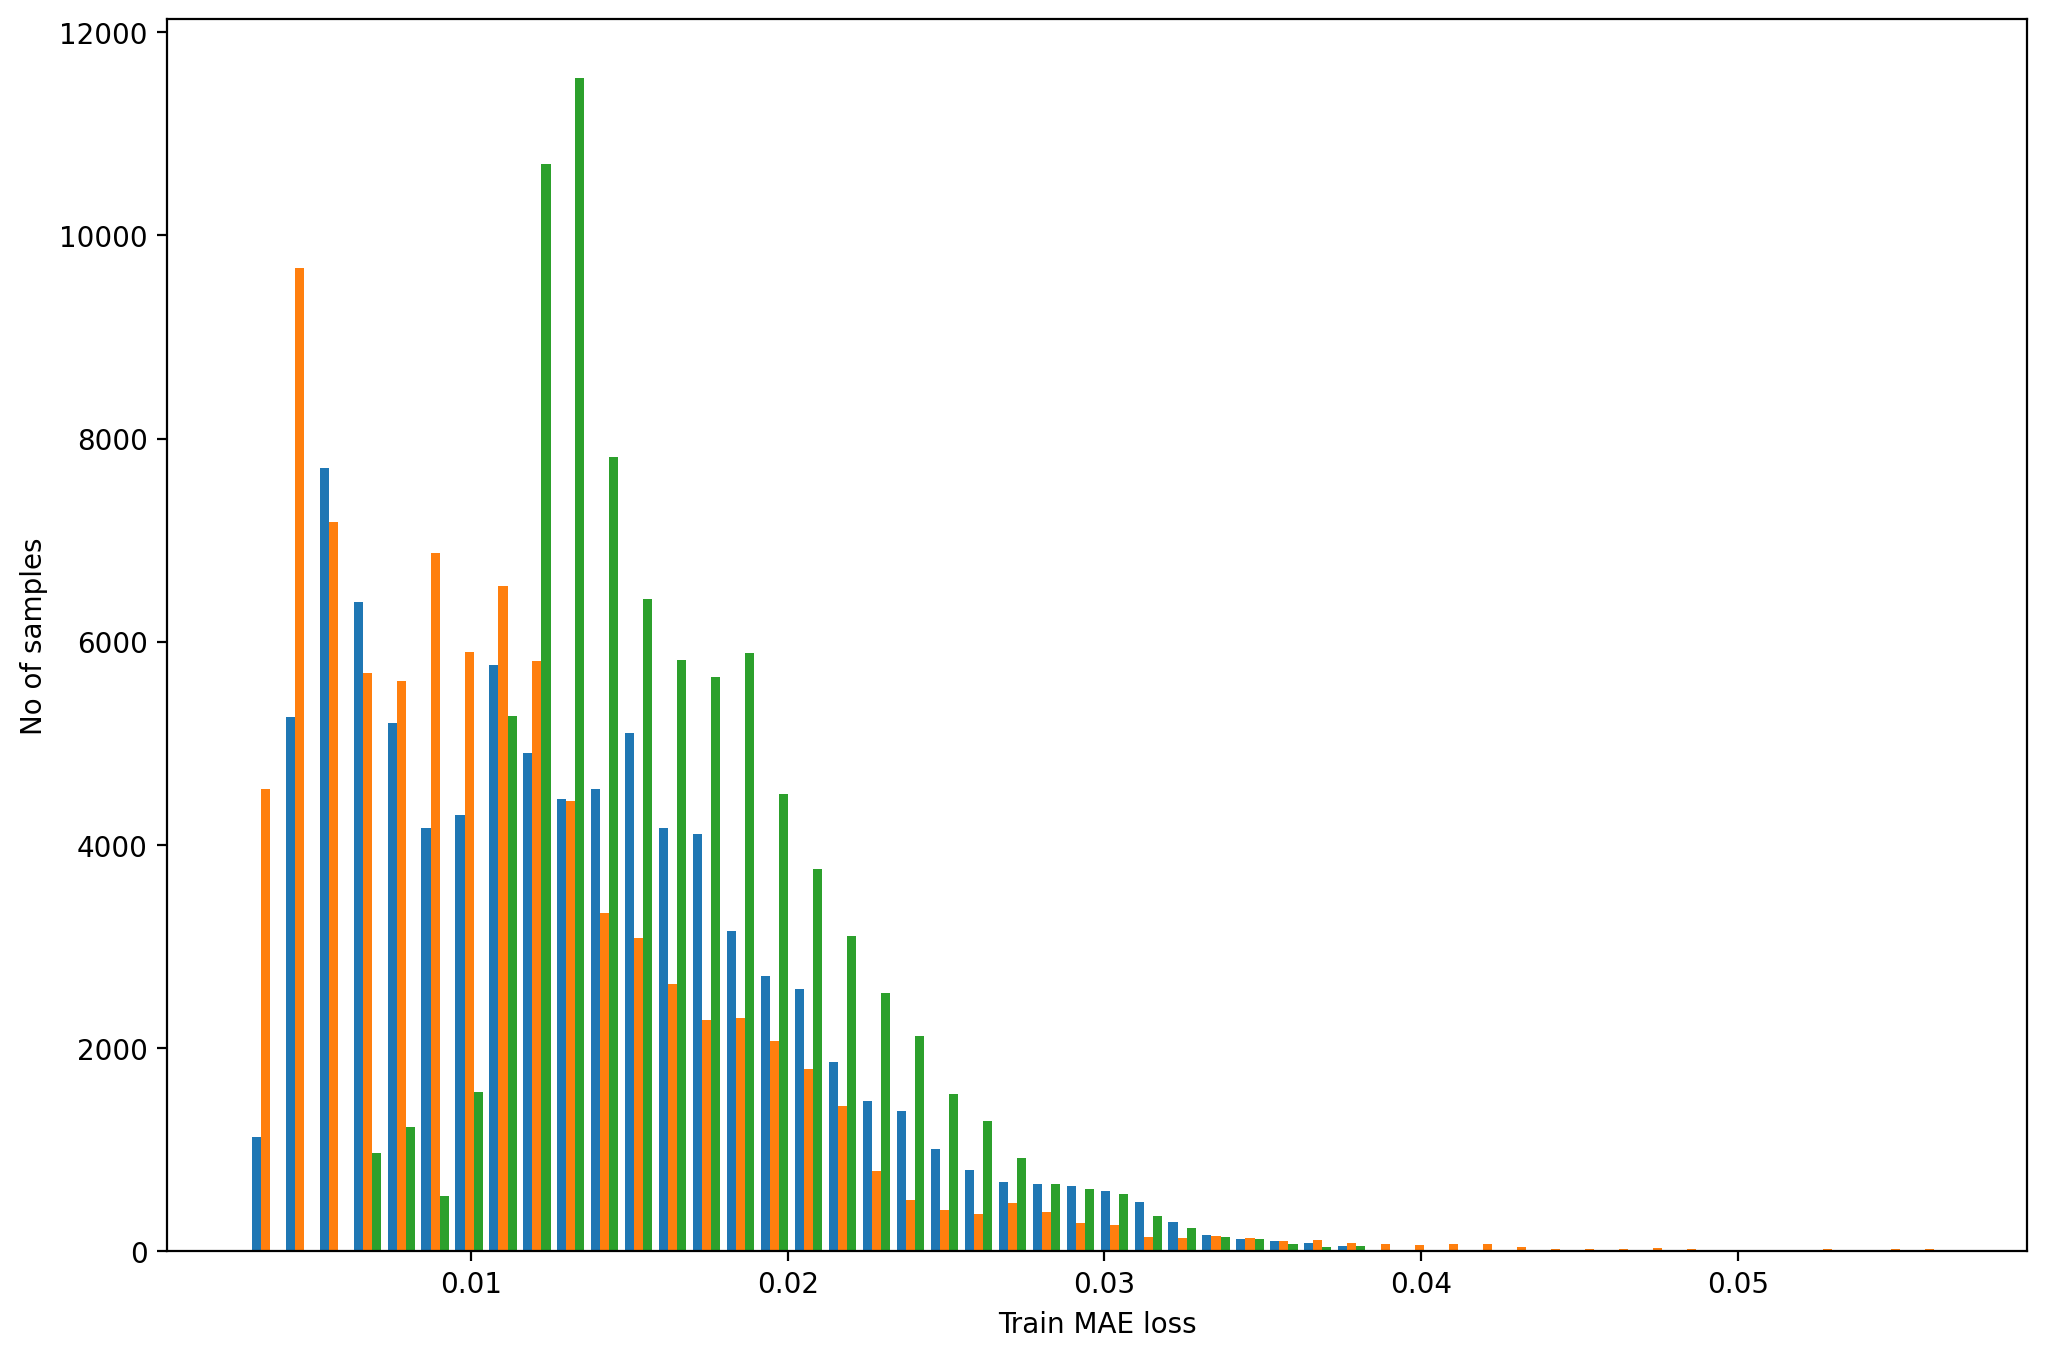

Reconstruction error threshold:  0.056571323


In [75]:
# Get train MAE loss.
x_train_pred = model.predict(x_train)
train_mae_loss = np.mean(np.abs(x_train_pred - x_train), axis=1)

plt.hist(train_mae_loss, bins=50)
plt.xlabel("Train MAE loss")
plt.ylabel("No of samples")
plt.show()

# Get reconstruction loss threshold.
threshold = np.max(train_mae_loss)
print("Reconstruction error threshold: ", threshold)

# Plot each vector's reconstruction loss
Here we plot the same data with a separate histgram for each vector.

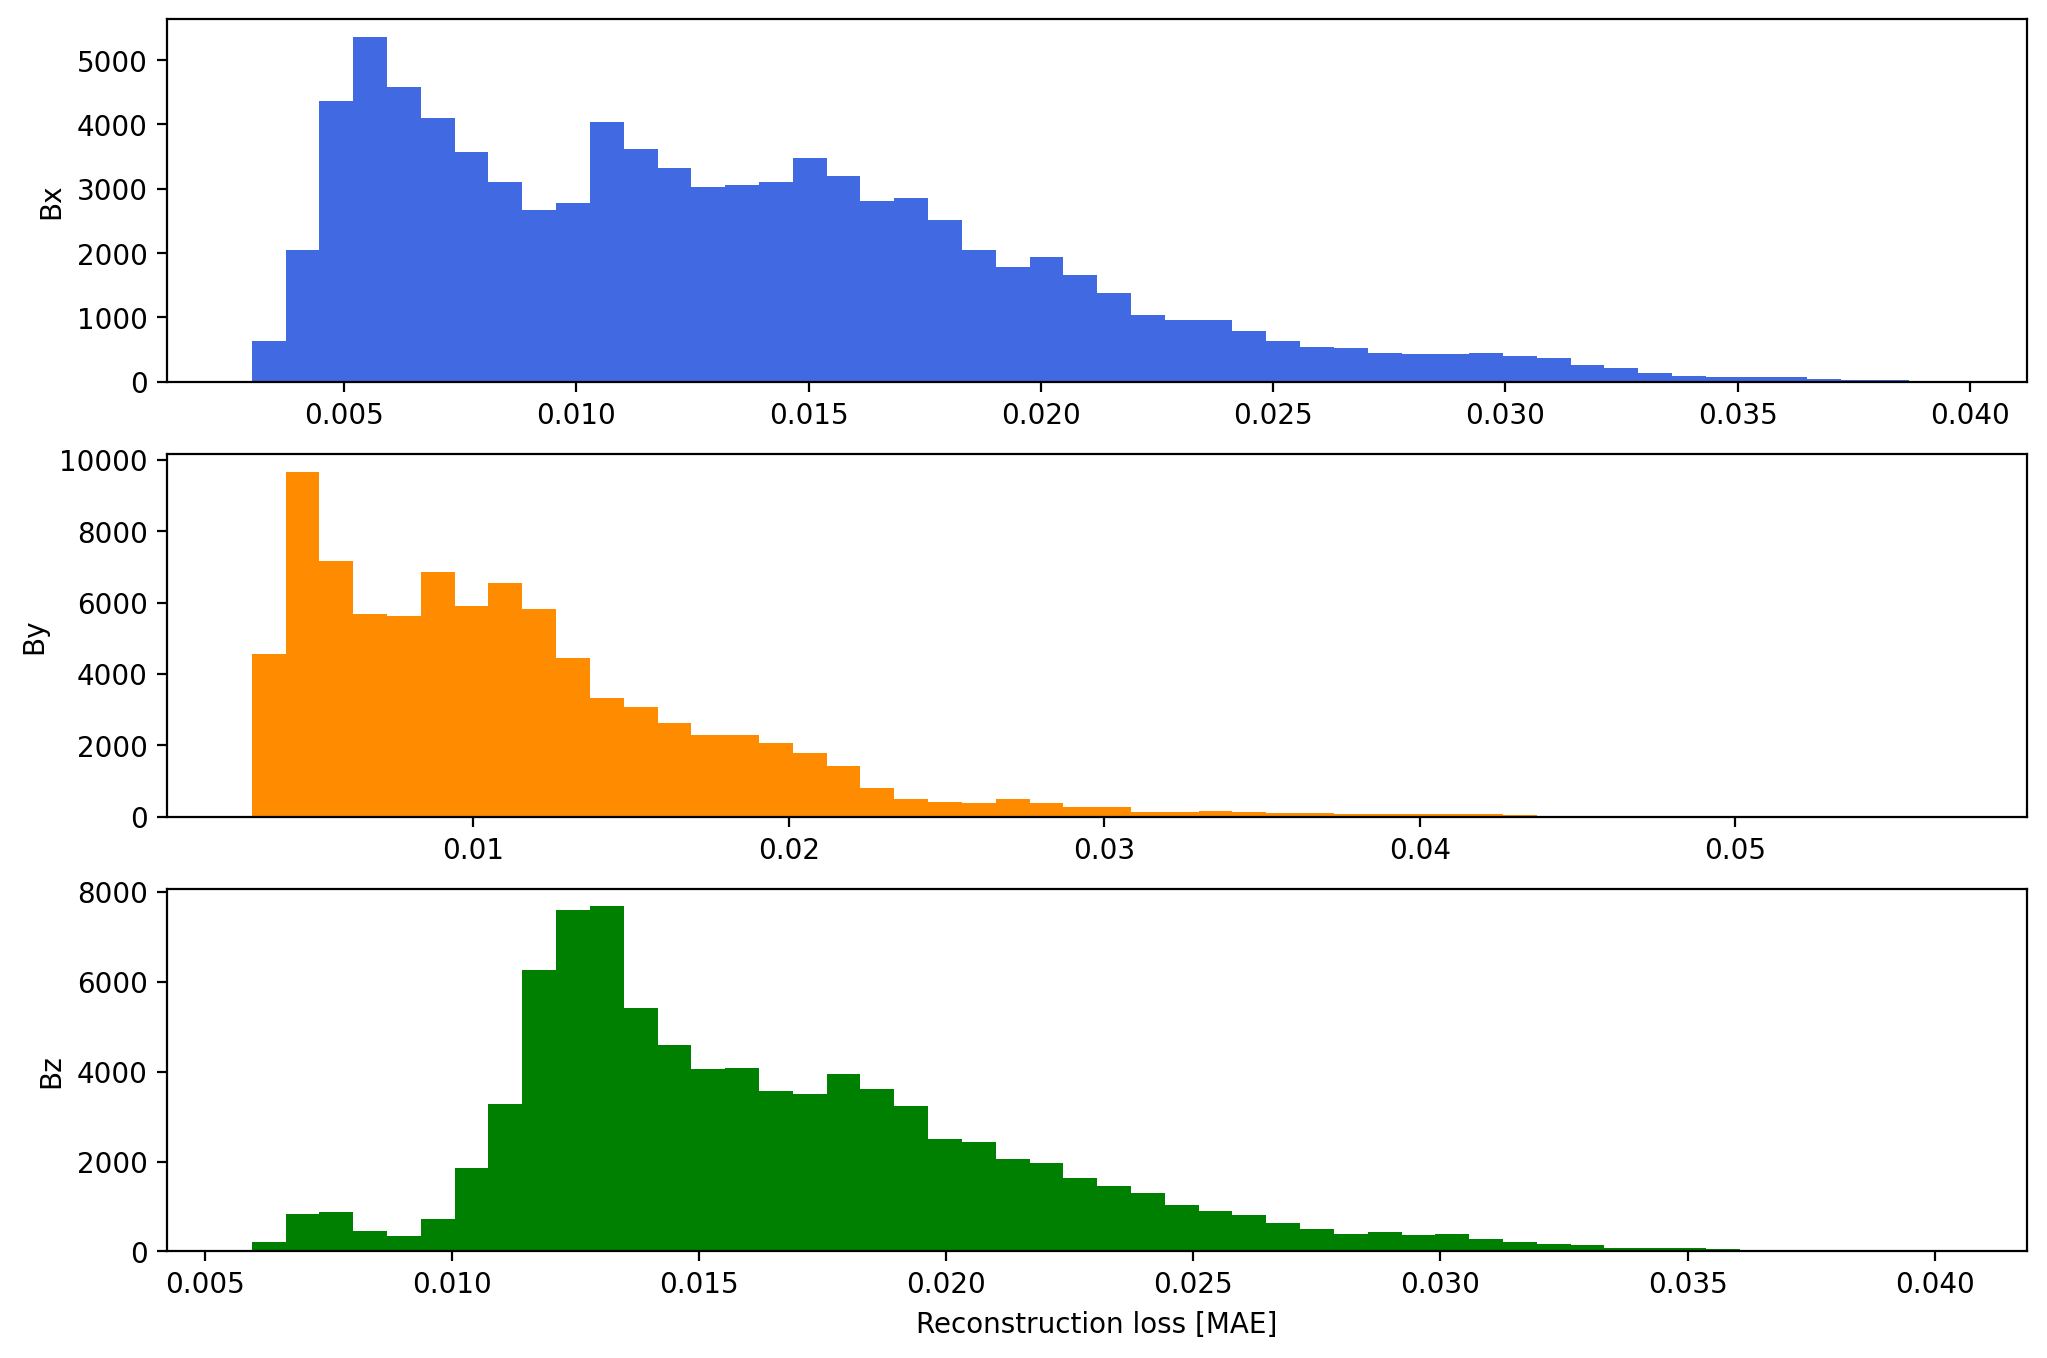

Reconstruction error threshold:  0.056571323


<Figure size 2400x1600 with 0 Axes>

In [76]:
# Get train MAE loss.
fig, axs = plt.subplots(3, 1)

x_train_pred = model.predict(x_train)
train_mae_loss = np.mean(np.abs(x_train_pred - x_train), axis=1)

axs[0].hist(train_mae_loss[:,0], color='royalblue', bins=50, label='Bx')
axs[1].hist(train_mae_loss[:,1], color='darkorange', bins=50, label='By')
axs[2].hist(train_mae_loss[:,2], color='green', bins=50, label='Bz')

axs[0].set(ylabel='Bx')
axs[1].set(ylabel='By')
axs[2].set(ylabel='Bz')

axs[2].set(xlabel='Reconstruction loss [MAE]')

plt.show()

# Get reconstruction loss threshold.
threshold = np.max(train_mae_loss)
print("Reconstruction error threshold: ", threshold)

plt.tight_layout()

# Set the desired anomaly threshold
We choose a value of 0.05 for anomaly detection

In [77]:
threshold = 0.05

# Visualize Fitting each Field Vector
We plot the actual and predicted values for each sequence to visualize the quality of the model's fit to the data.

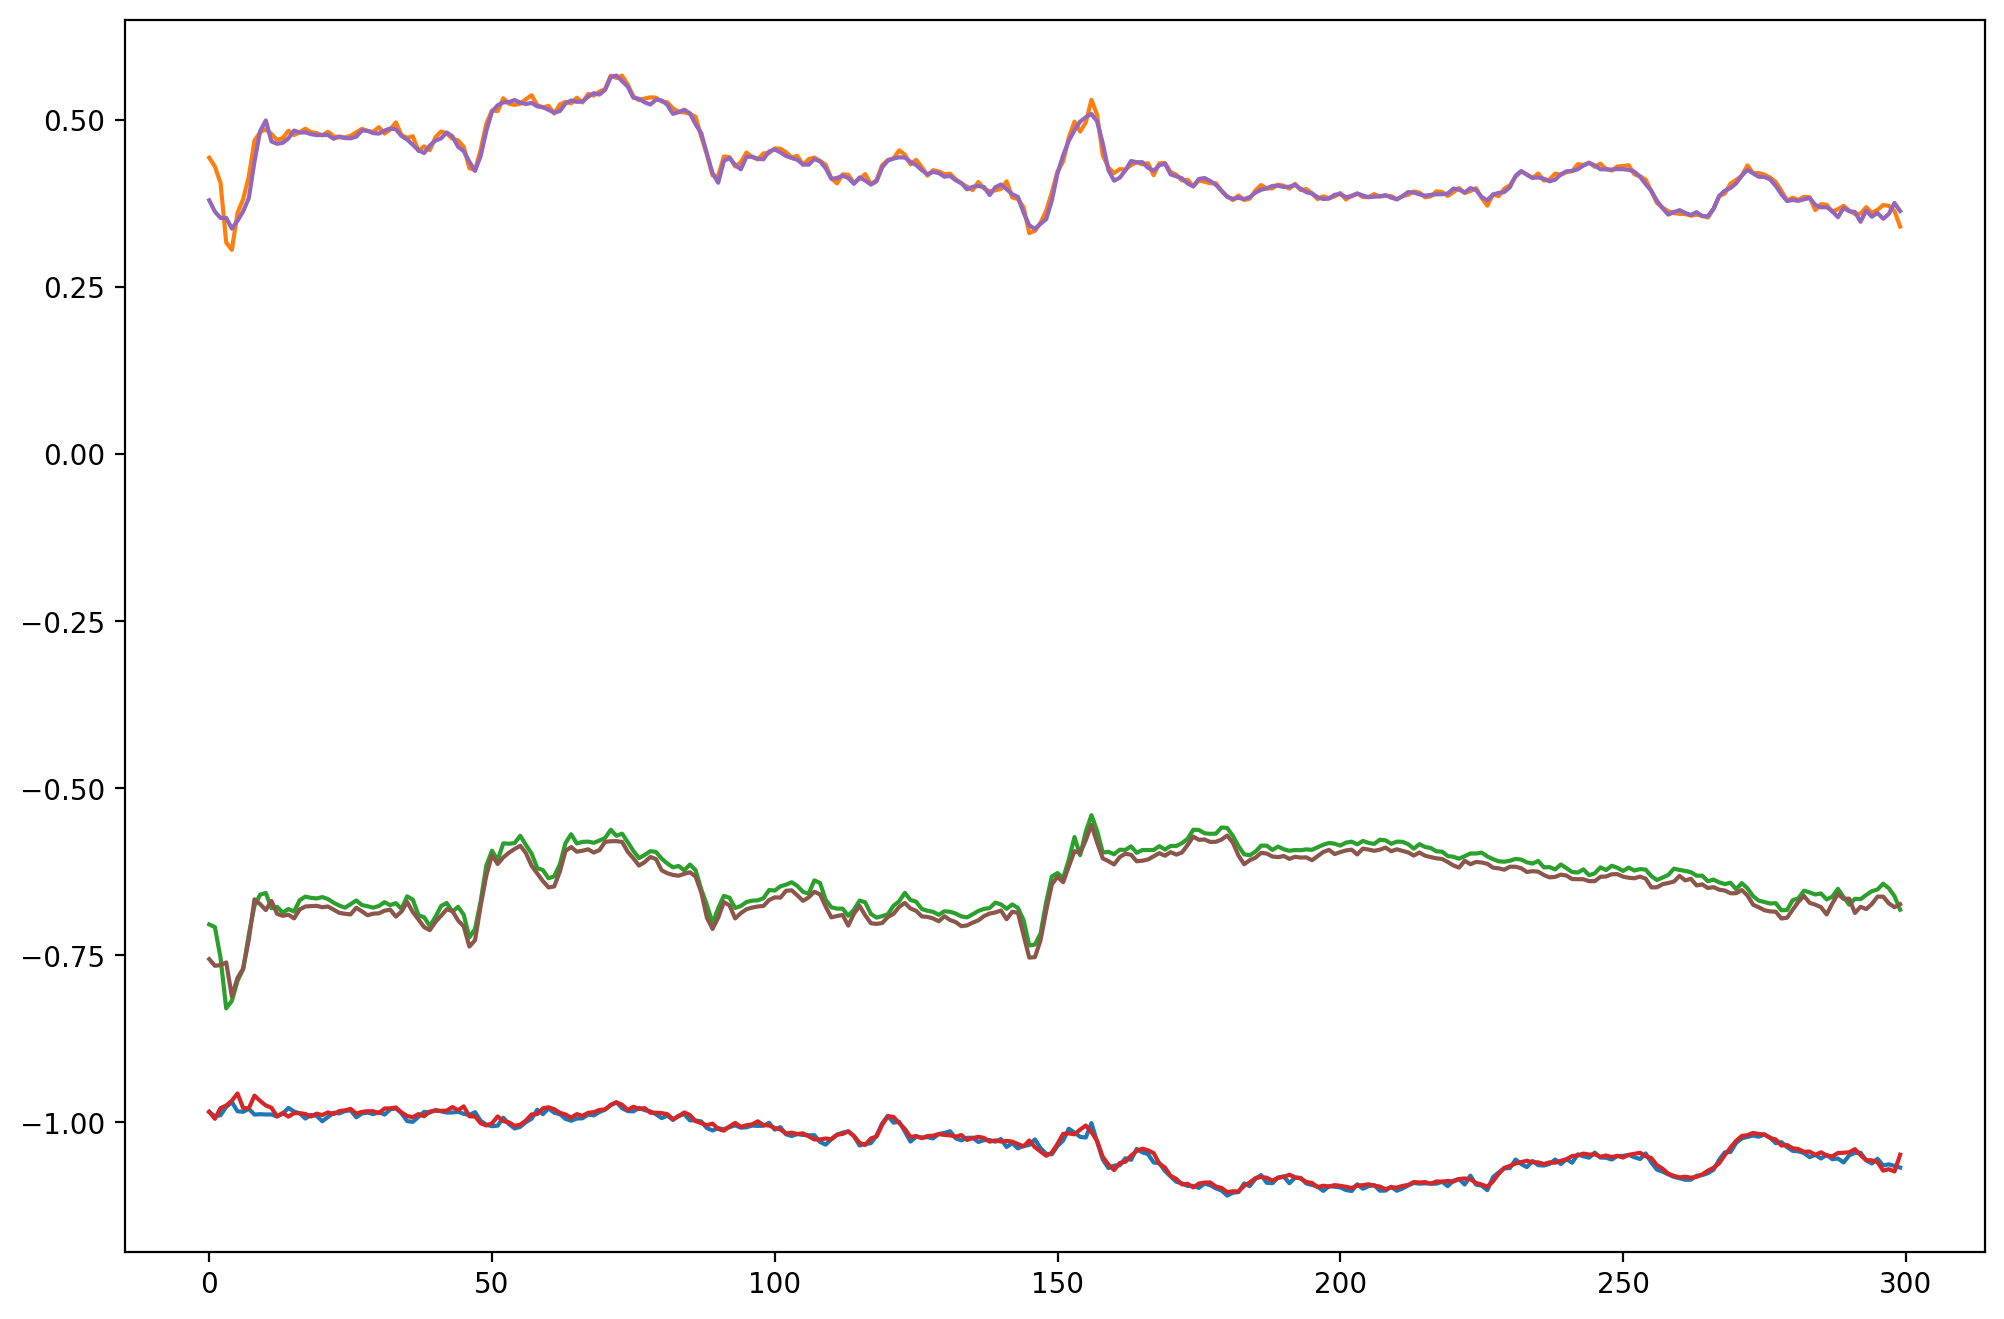

In [78]:
# Checking how the first sequence is learnt
plt.plot(x_train[0])
plt.plot(x_train_pred[0])
plt.show()

# Detect Anomalies
Finally, we compute use the DSCOVR data as our test set and look for anomalies.
As above, we normalize the DSCOVR data.
Then we parse it into sequences.
Then we use our model to predict the input from itself.
We compute the MAE reconstruction error on the prediction vs the actual values.
Any sequences having an MAE greater than the threshold are selected as anomalies.

(86400, 3)
Test input shape:  (86101, 300, 3)
Test output shape:  (86101, 300, 3)
(86101, 3)


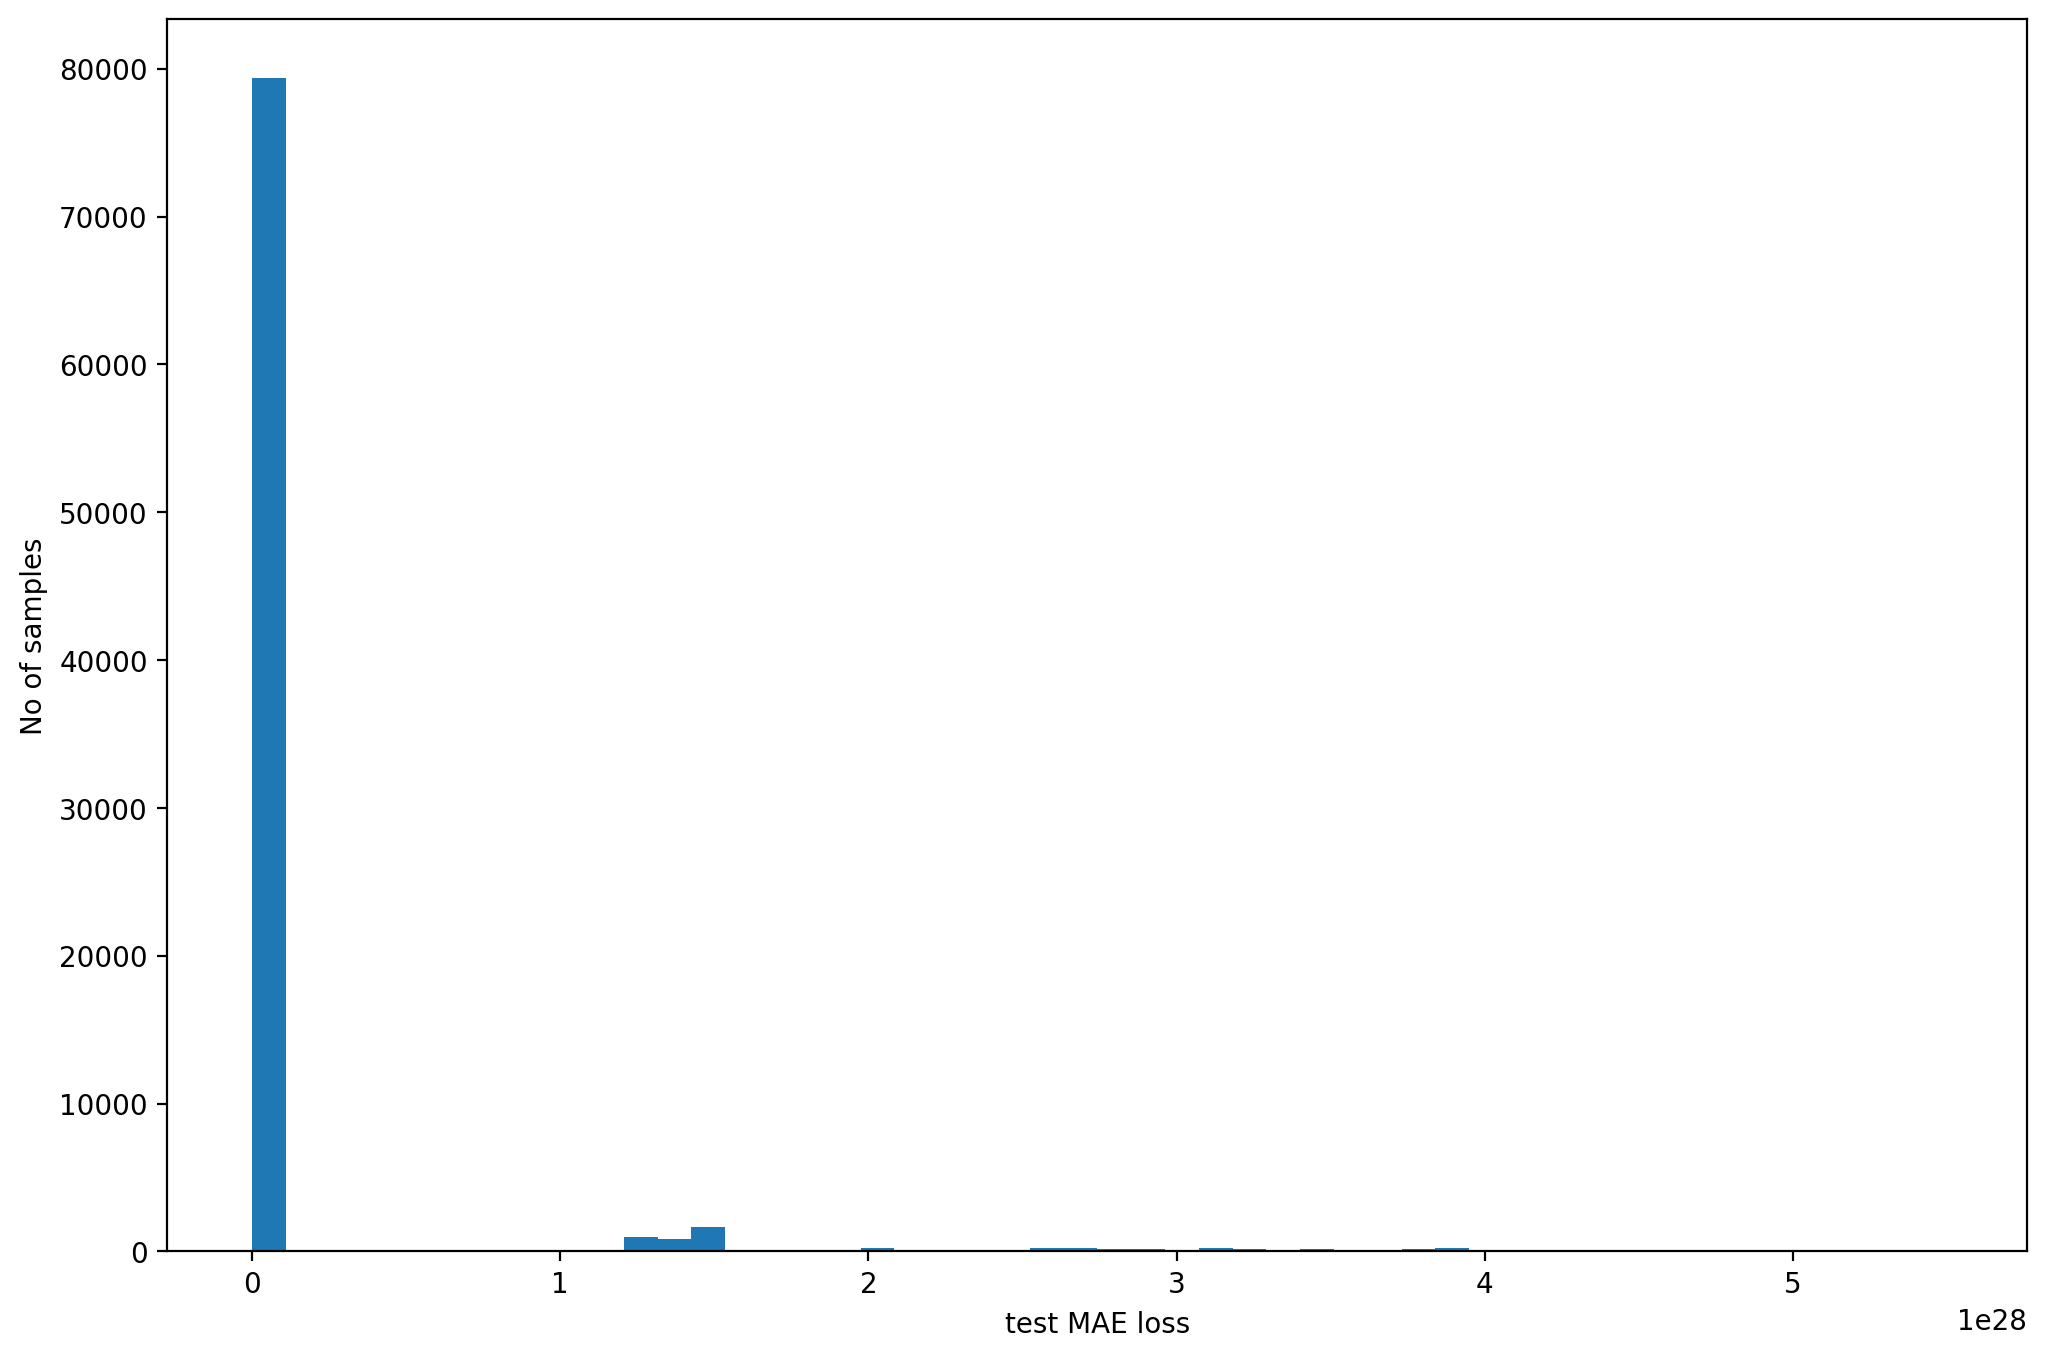

Number of anomaly samples:  6984
Indices of anomaly samples:  (array([ 1945,  1946,  1947, ..., 83497, 83498, 83499]),)


In [79]:
print(d_b.shape)
df_test_value = (d_b  - training_mean) / training_std

x_test = create_sequences(df_test_value)
print("Test input shape: ", x_test.shape)

# Get test MAE loss.
x_test_pred = model.predict(x_test)
print("Test output shape: ", x_test_pred.shape)
test_mae_loss = np.mean(np.abs(x_test_pred - x_test), axis=1)

#test_mae_loss = test_mae_loss.reshape((-1))
print(test_mae_loss.shape)

plt.hist(test_mae_loss[:,0], bins=50)
plt.xlabel("test MAE loss")
plt.ylabel("No of samples")
plt.show()

# Detect all the samples which are anomalies.
anomalies = test_mae_loss[:,0] > threshold
print("Number of anomaly samples: ", np.sum(anomalies))
print("Indices of anomaly samples: ", np.where(anomalies))

# Evaluate Fit on DSCOVR data
It is very important to evaluate how well the model, trained on WIND data, fits the DSCOVR data.
Keep in mind, the DSCOVR data was never see during training.
Wow, this looks really good!

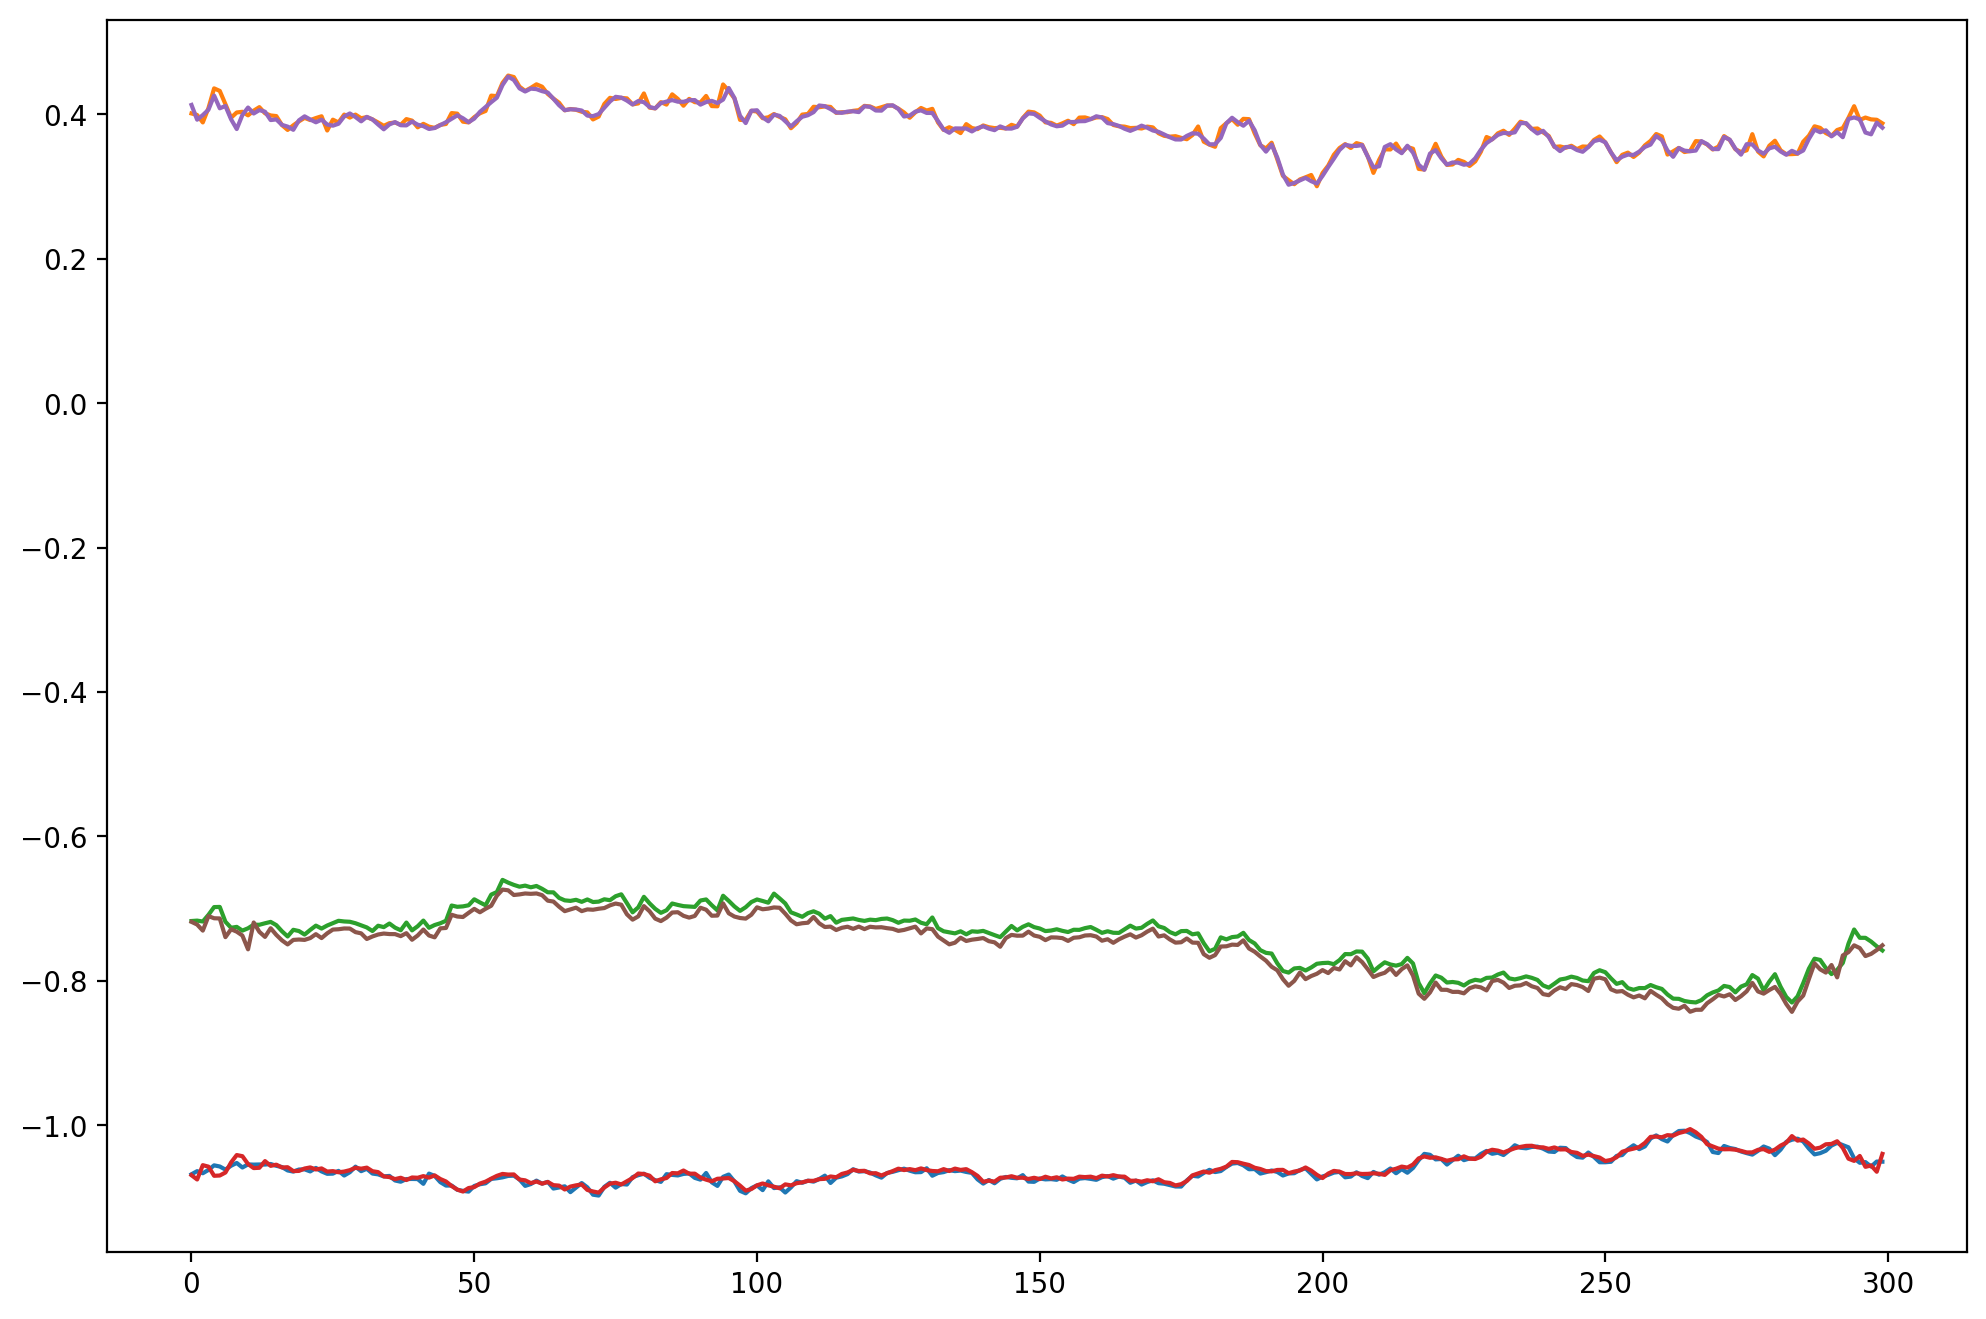

In [80]:
# Checking how the first sequence is learnt
plt.plot(x_test[0])
plt.plot(x_test_pred[0])
plt.show()

# Histogram Plot of Reconstruction Error
As we did with the training data, we plot a histogram over the reconstrucion MAE error on the DSCOVR data.
There are definitely some outliers ranging from a little less than 1 to 4. Much higher than our threshold of 0.05.

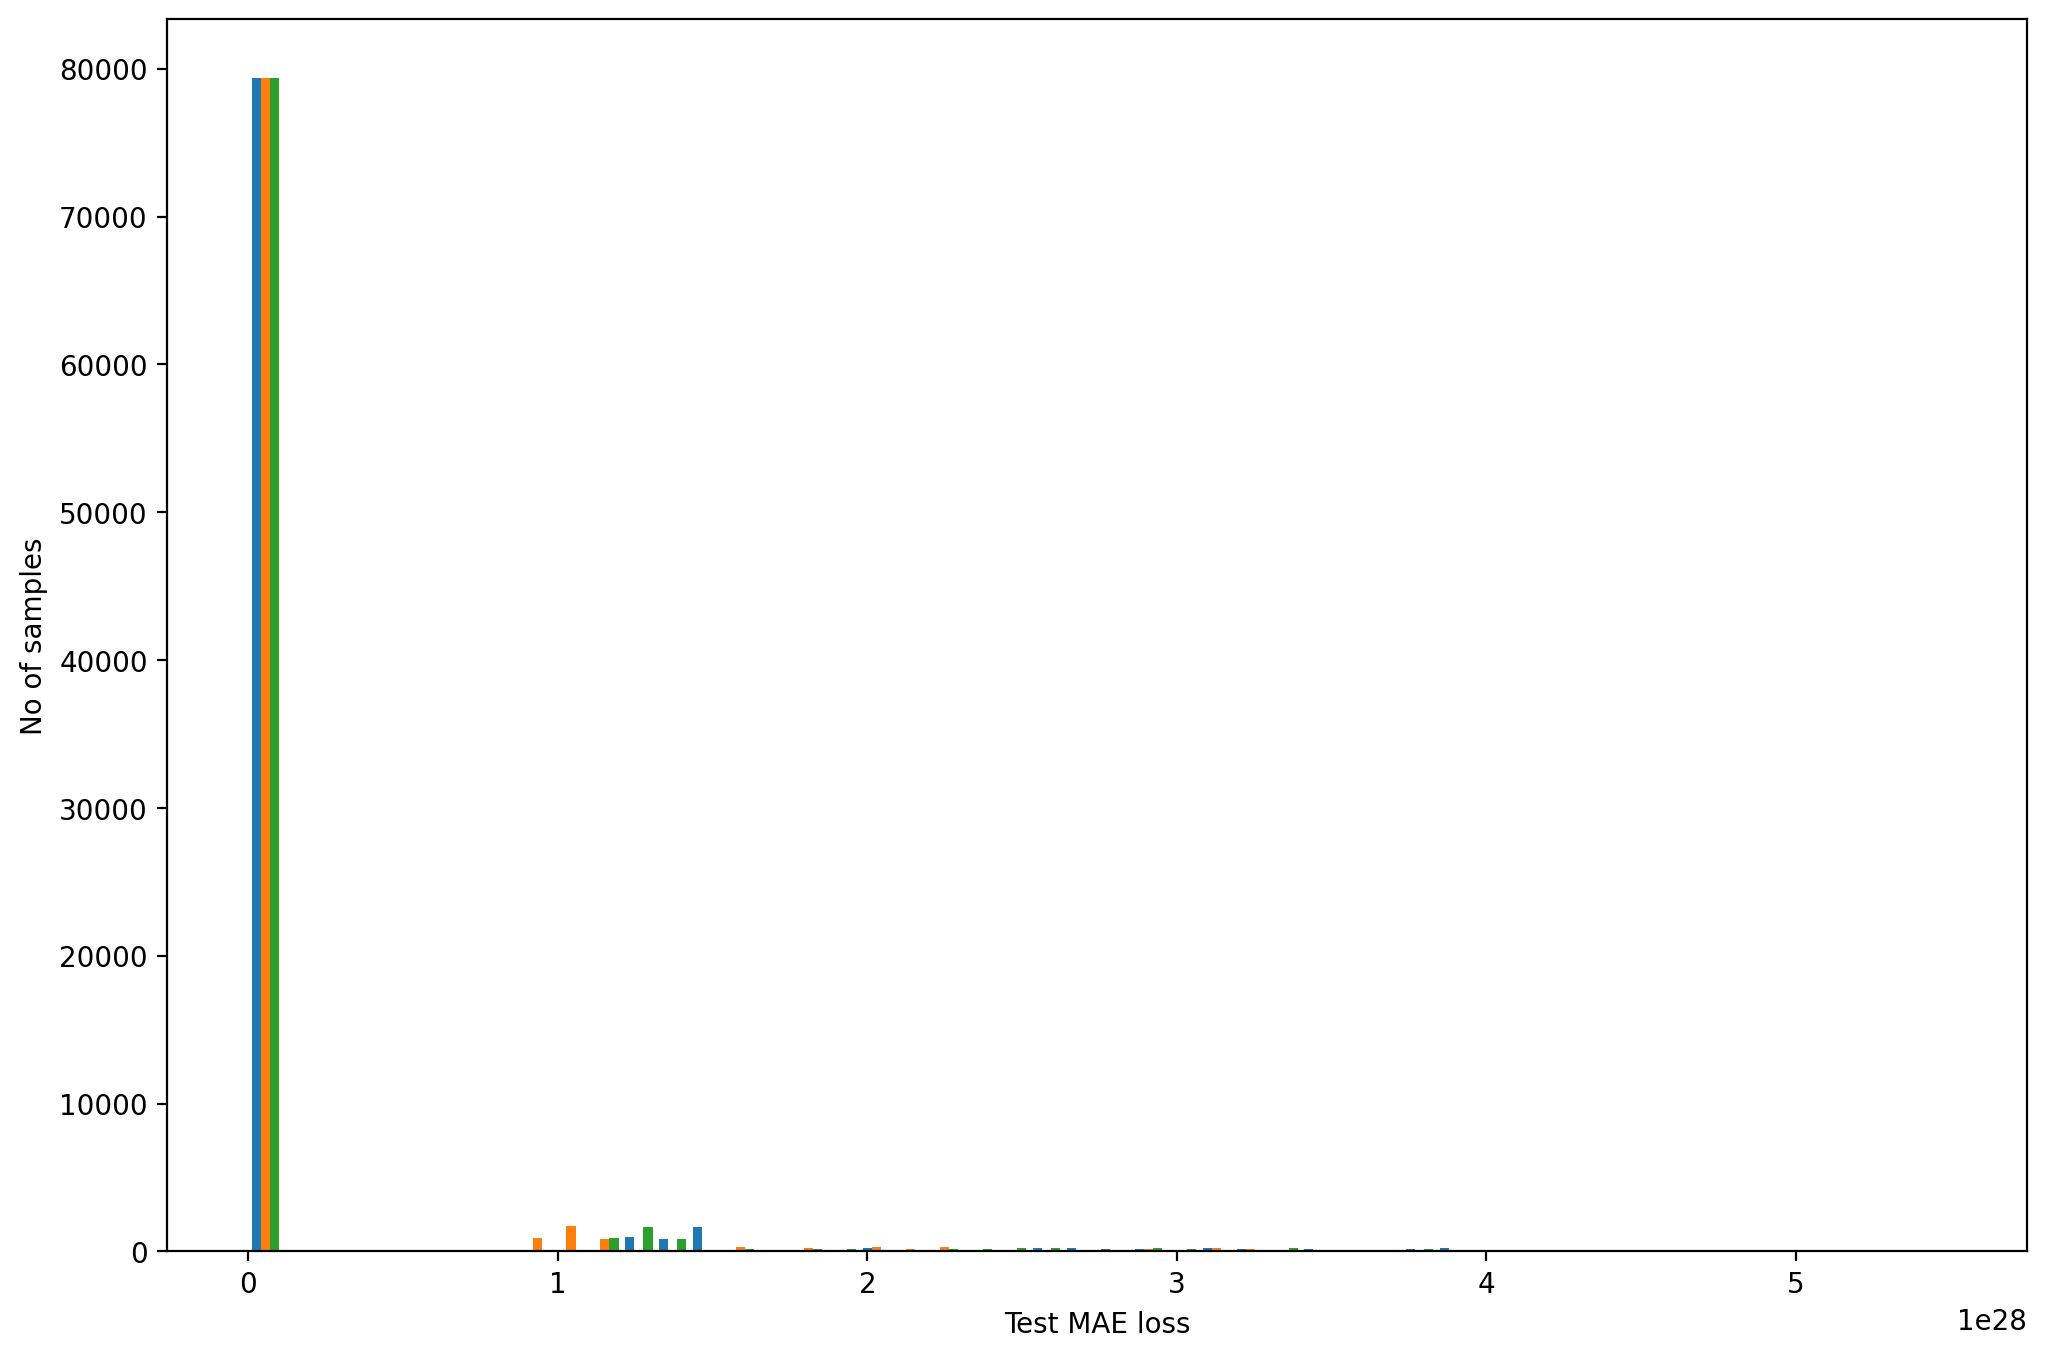

Reconstruction error threshold:  5.4858485e+28


In [81]:
# Get train MAE loss.
test_mae_loss = np.mean(np.abs(x_test_pred - x_test), axis=1)

plt.hist(test_mae_loss, bins=50)
plt.xlabel("Test MAE loss")
plt.ylabel("No of samples")
plt.show()

# Get reconstruction loss threshold.
threshold = np.max(test_mae_loss)
print("Reconstruction error threshold: ", threshold)

# Find the Anomalies - method 1
We make one pass though the sequences checking whether each one is an anomaly.
If so, we add its index to a list of anomaly indices.

In [82]:
# data i is an anomaly if samples [(i - timesteps + 1) to (i)] are anomalies
anomalous_data_indices = []
#for data_idx in range(TIME_STEPS - 1, len(df_test_value) - TIME_STEPS + 1):
for data_idx in range(TIME_STEPS - 1, len(df_test_value)):
    if np.all(anomalies[data_idx - TIME_STEPS + 1 : data_idx]):
        anomalous_data_indices.append(data_idx)

# Find the Anomalies - method 2
Here we select the indices of anomalous data points.
The difference to the above approach is we don't check for **ALL** steps of each sequence being anomalous.

In [83]:
anomalous_data_indices = np.where(anomalies)[0]
print(len(anomalous_data_indices))

6984


# Visualize the Anomalies
We overplot the anomalies in red so we can see them.

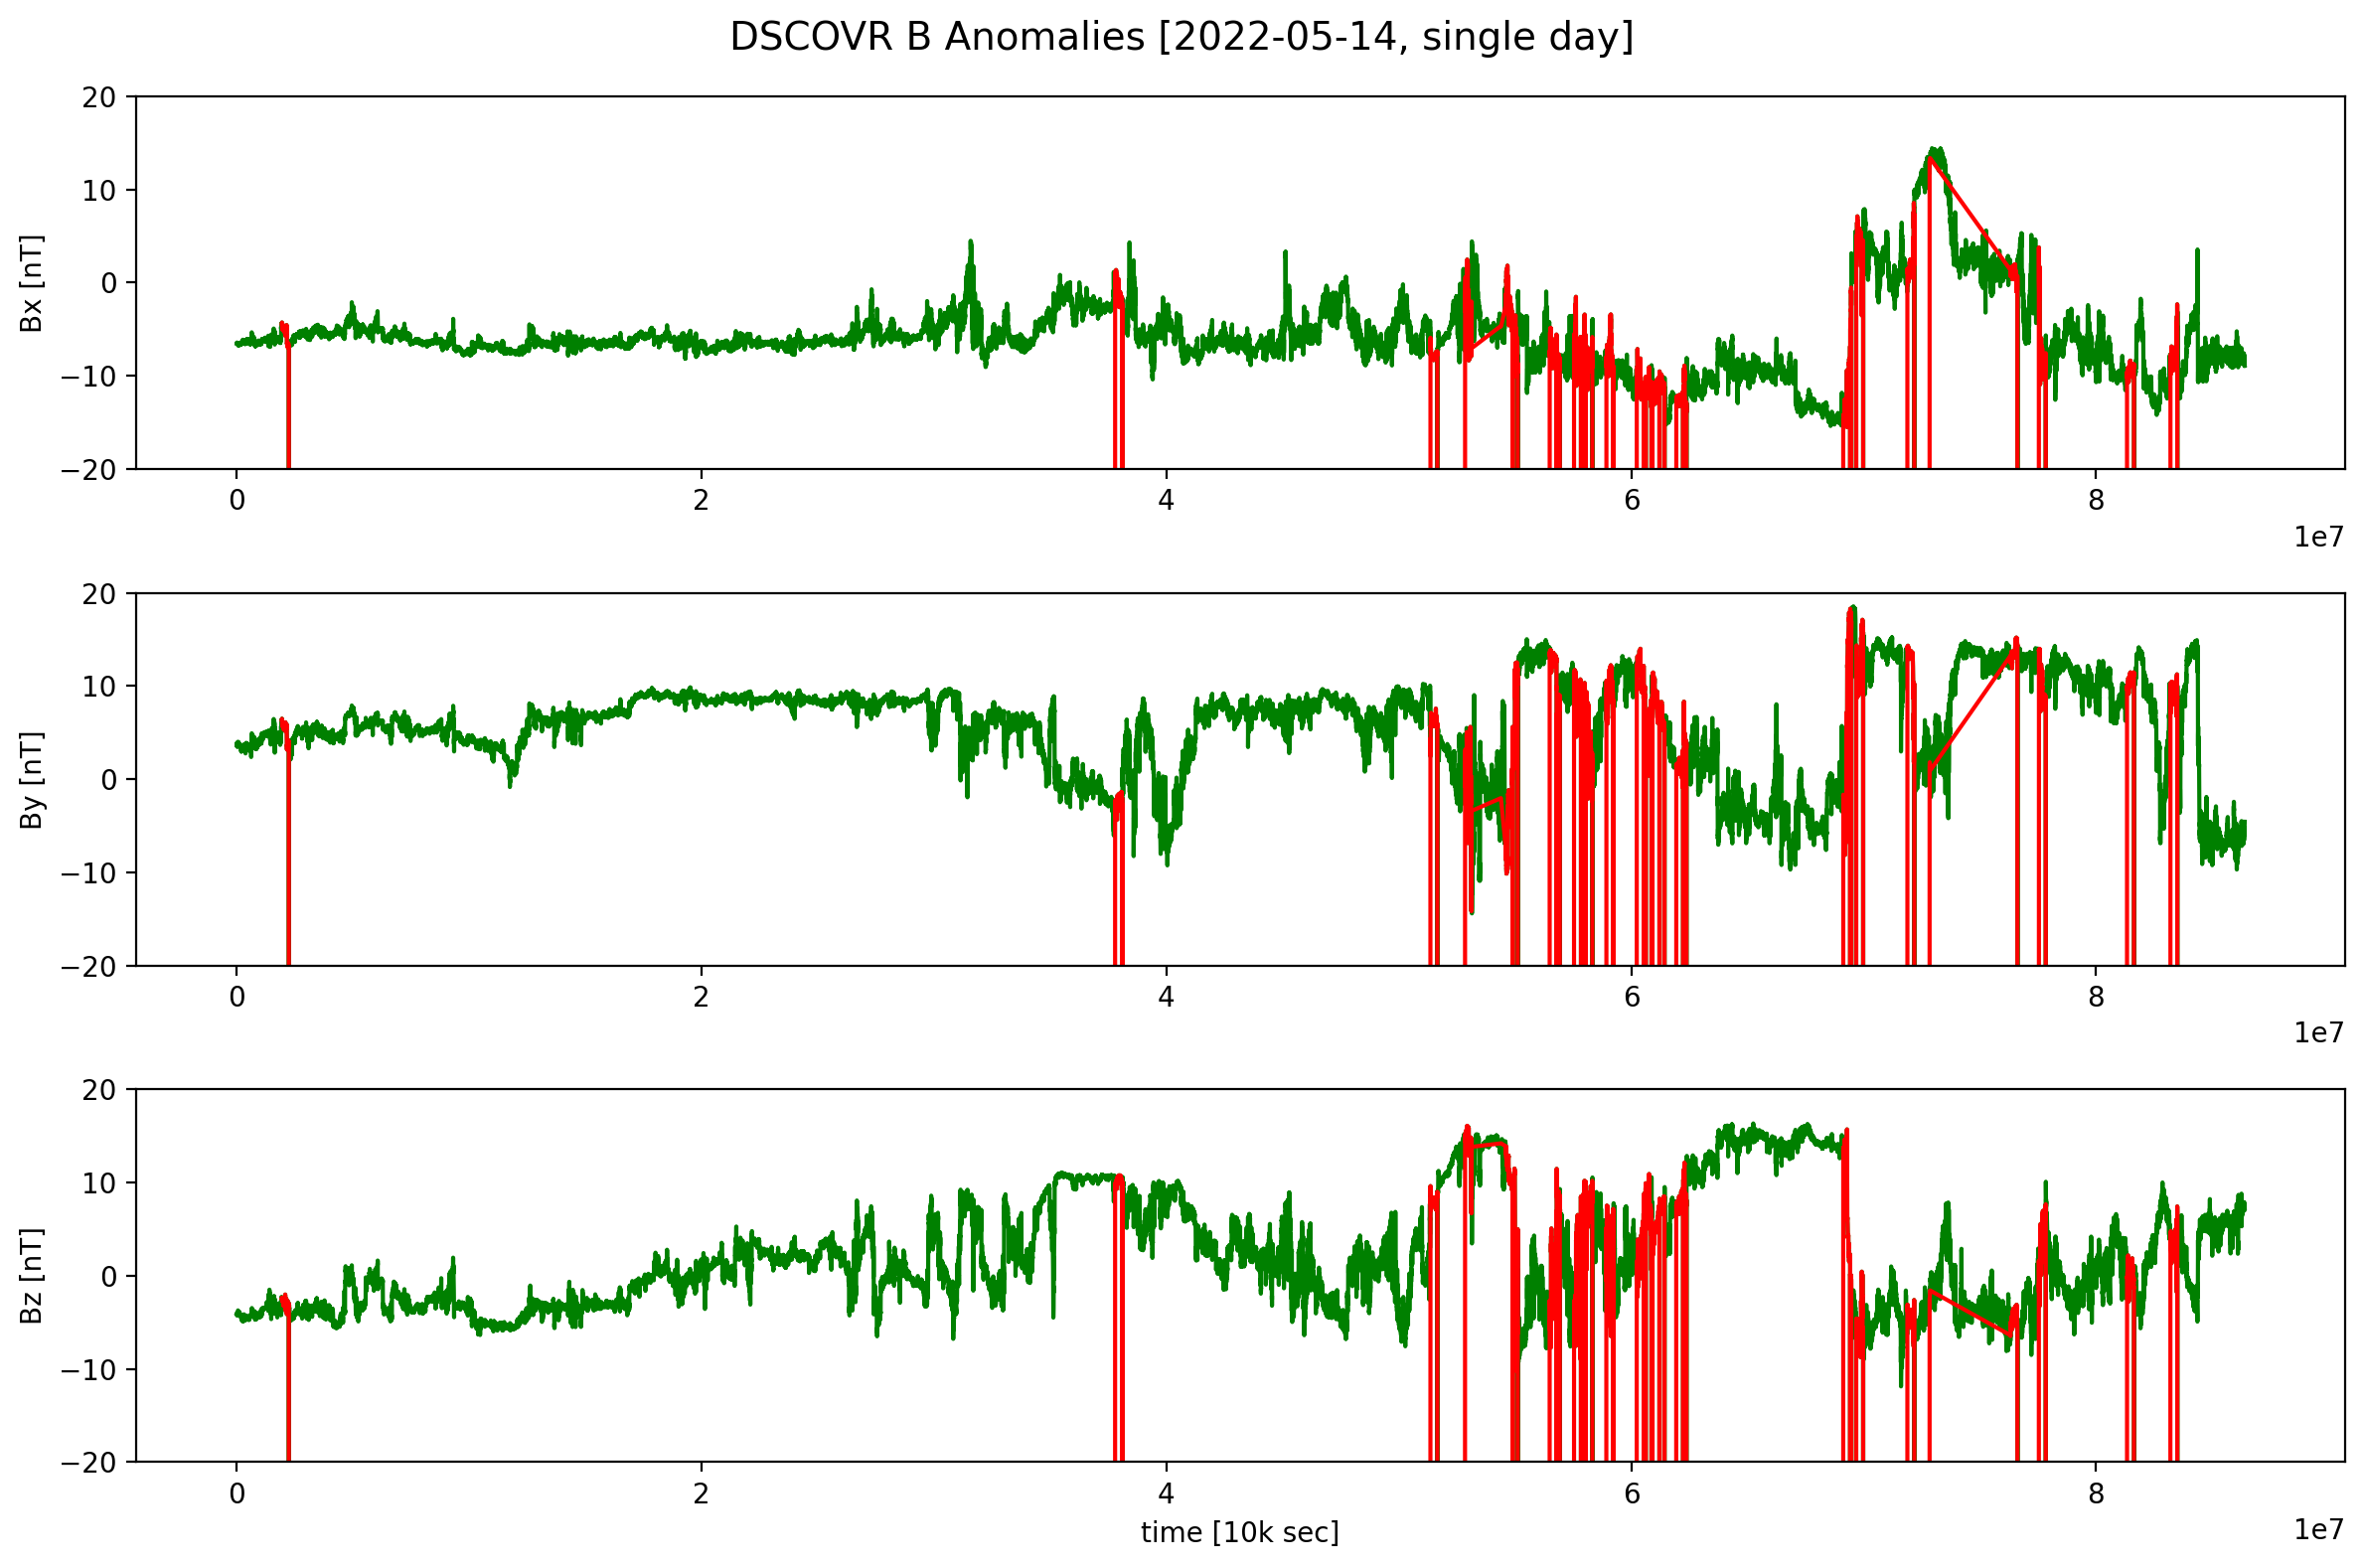

In [84]:
fig, axs = plt.subplots(3, 1)
title = 'DSCOVR B Anomalies [2022-05-14, single day]'
fig.suptitle(title, fontsize=14)

d_t = np.asarray(dsc_t[:,:])
d_b = np.asarray(dsc_B[:,:])
a_t = d_t[anomalous_data_indices]
a_b = d_b[anomalous_data_indices]

d_bx, = axs[0].plot(dsc_t[:,2], dsc_B[:,0], color=dsc_colour, label='Bx')
d_by, = axs[1].plot(dsc_t[:,2], dsc_B[:,1], color=dsc_colour, label='By')
d_bz, = axs[2].plot(dsc_t[:,2], dsc_B[:,2], color=dsc_colour, label='Bz')

a_bx, = axs[0].plot(a_t[:,2], a_b[:,0], color=anl_colour)
a_by, = axs[1].plot(a_t[:,2], a_b[:,1], color=anl_colour)
a_bz, = axs[2].plot(a_t[:,2], a_b[:,2], color=anl_colour)

axs[0].set(ylabel='Bx [nT]')
axs[1].set(ylabel='By [nT]')
axs[2].set(ylabel='Bz [nT]')

axs[0].set(ylim=(-20,20))
axs[1].set(ylim=(-20,20))
axs[2].set(ylim=(-20,20))

axs[2].set(xlabel='time [10k sec]')

plt.tight_layout()

# Plot the correlated WIND data

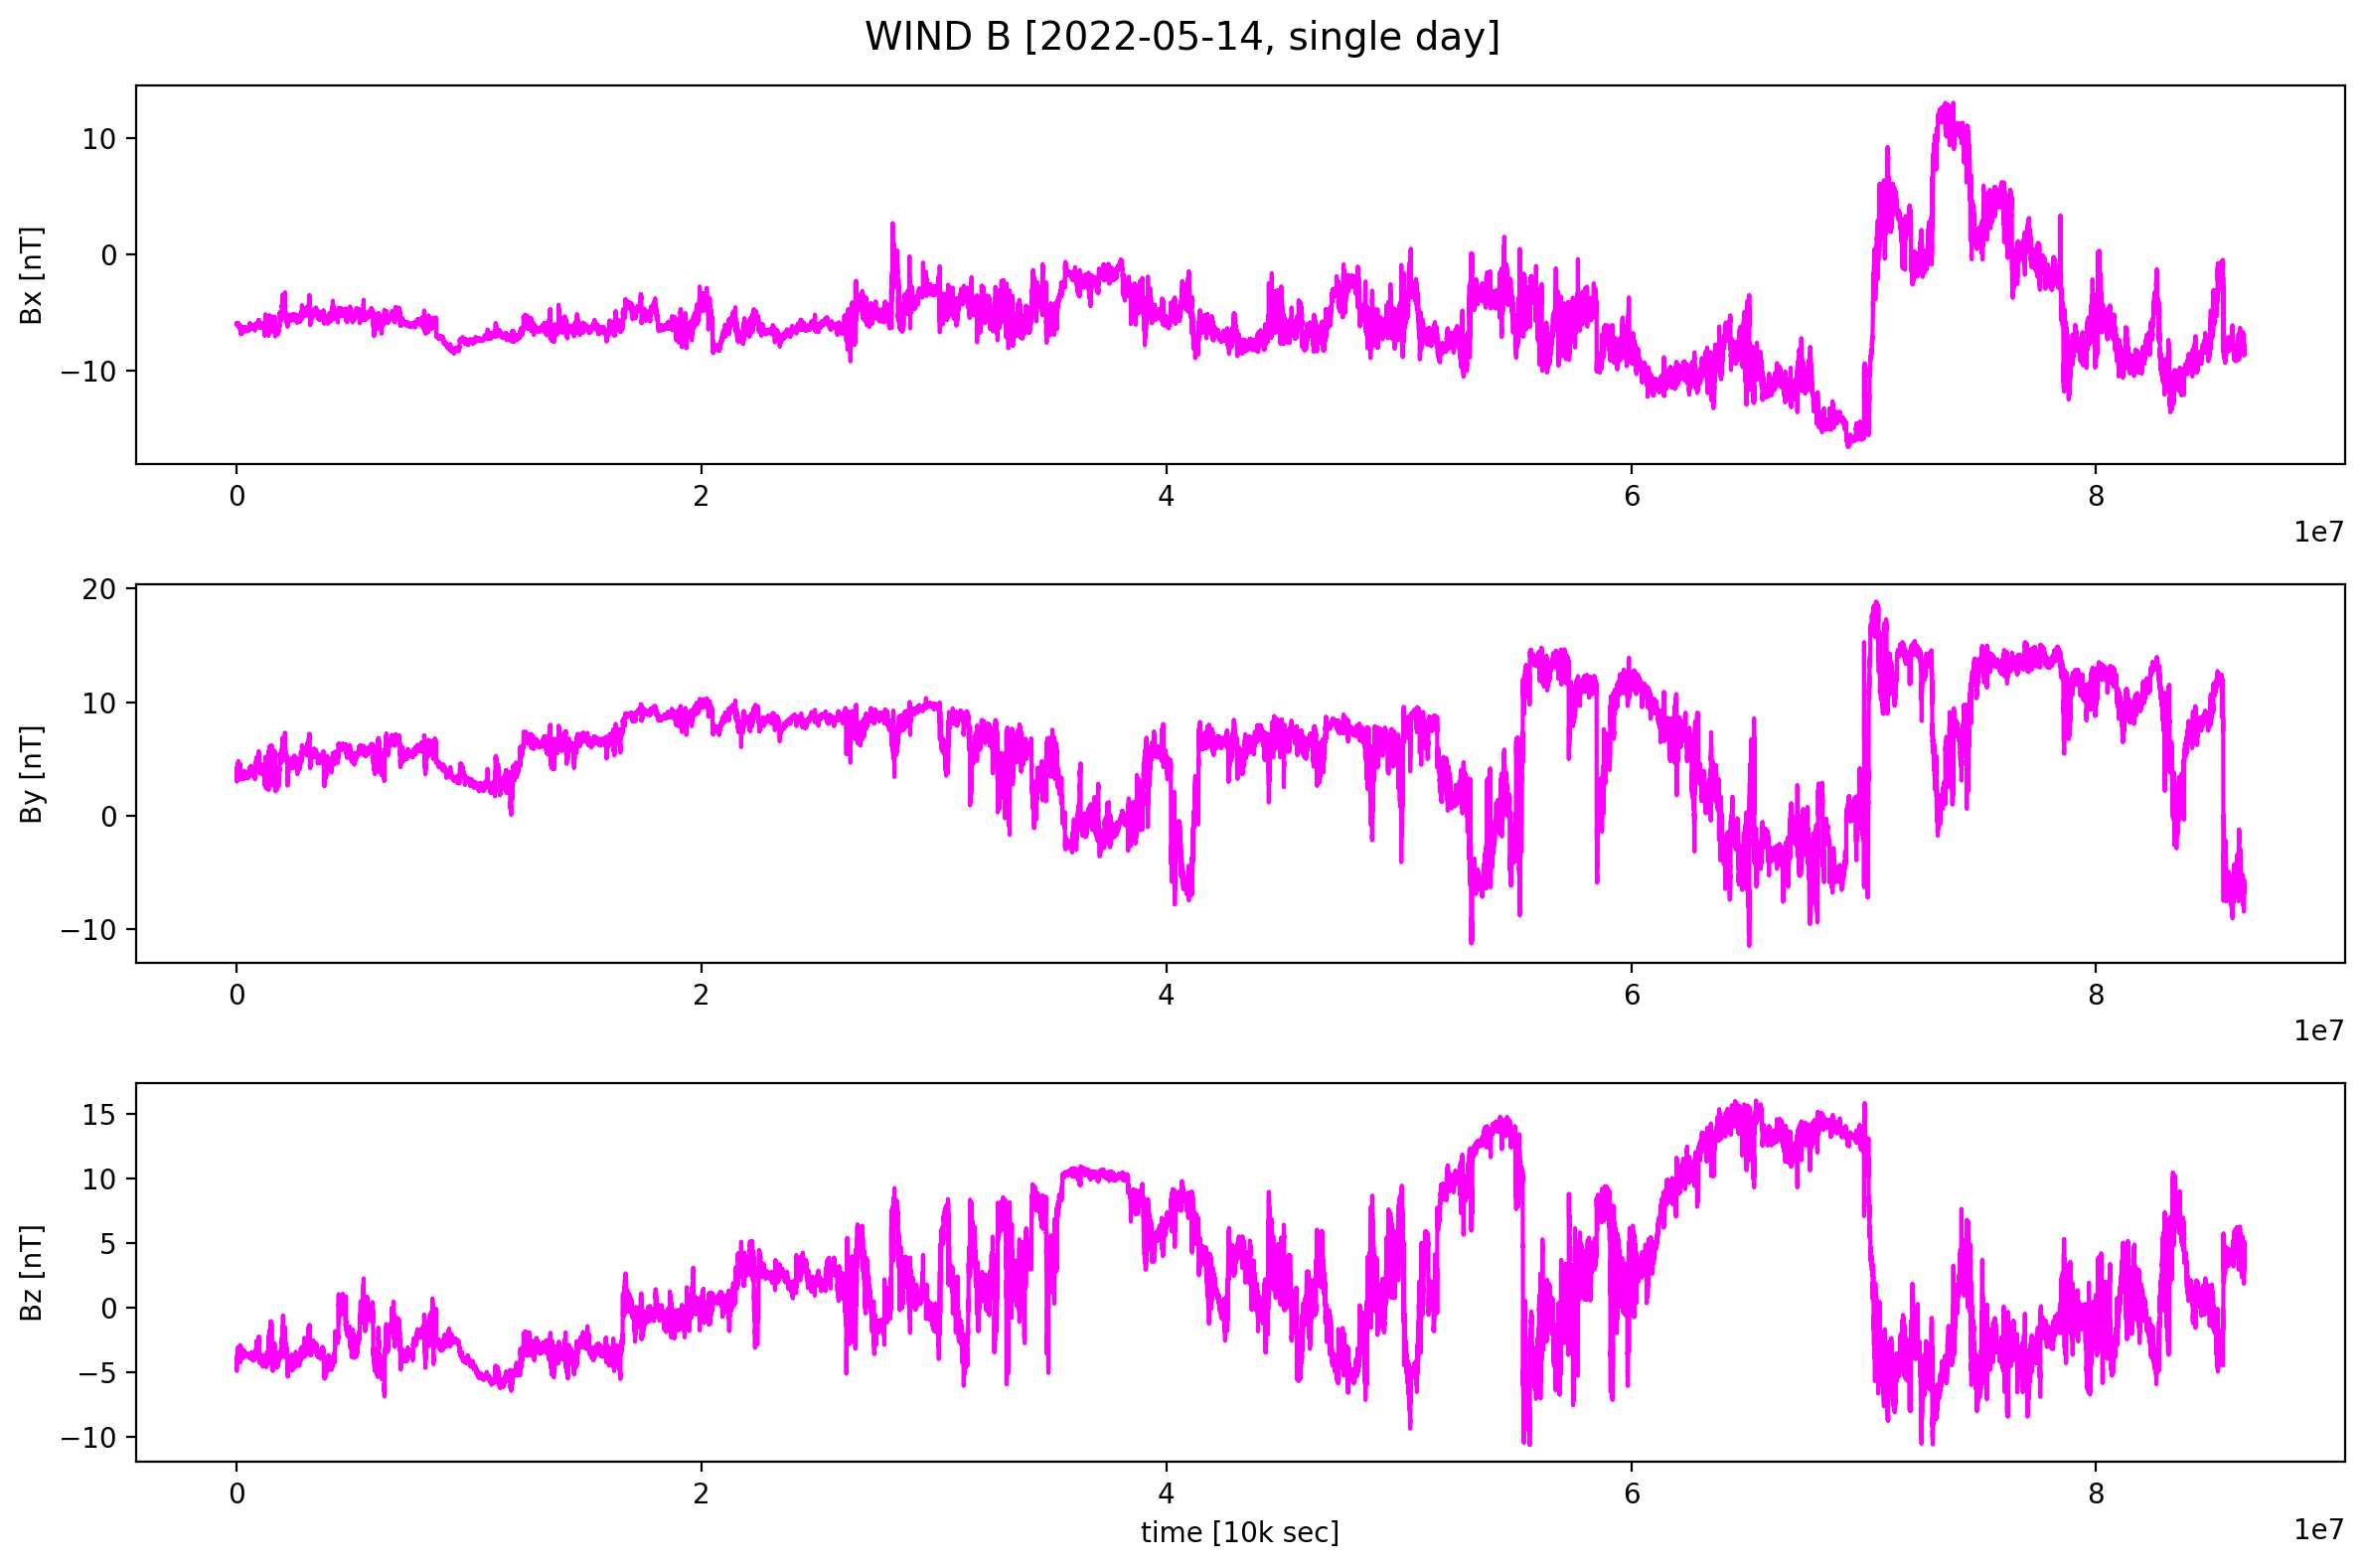

In [85]:
fig, axs = plt.subplots(3, 1)
title = 'WIND B [2022-05-14, single day]'
fig.suptitle(title, fontsize=14)

w_t = np.asarray(wnd_t[:,:])
w_b = np.asarray(wnd_B[:,:])

w_bx, = axs[0].plot(w_t[wnd_t_ix,2], w_b[wnd_t_ix,0], color=wnd_colour, label='Bx')
w_by, = axs[1].plot(w_t[wnd_t_ix,2], w_b[wnd_t_ix,1], color=wnd_colour, label='By')
w_bz, = axs[2].plot(w_t[wnd_t_ix,2], w_b[wnd_t_ix,2], color=wnd_colour, label='Bz')

axs[0].set(ylabel='Bx [nT]')
axs[1].set(ylabel='By [nT]')
axs[2].set(ylabel='Bz [nT]')

#axs[0].set(ylim=(-20,20))
#axs[1].set(ylim=(-20,20))
#axs[2].set(ylim=(-20,20))

axs[2].set(xlabel='time [10k sec]')

plt.tight_layout()

# Filter the Anomalies
We invert the list of anomalies to get indices of all the good data points.

In [86]:
good_data_indices = np.where(np.logical_not(anomalies))[0]
print(len(good_data_indices))

79117


# Plot the Corrected Data
Finally, we can plot the DSCOVR data with the anomalous data removed.

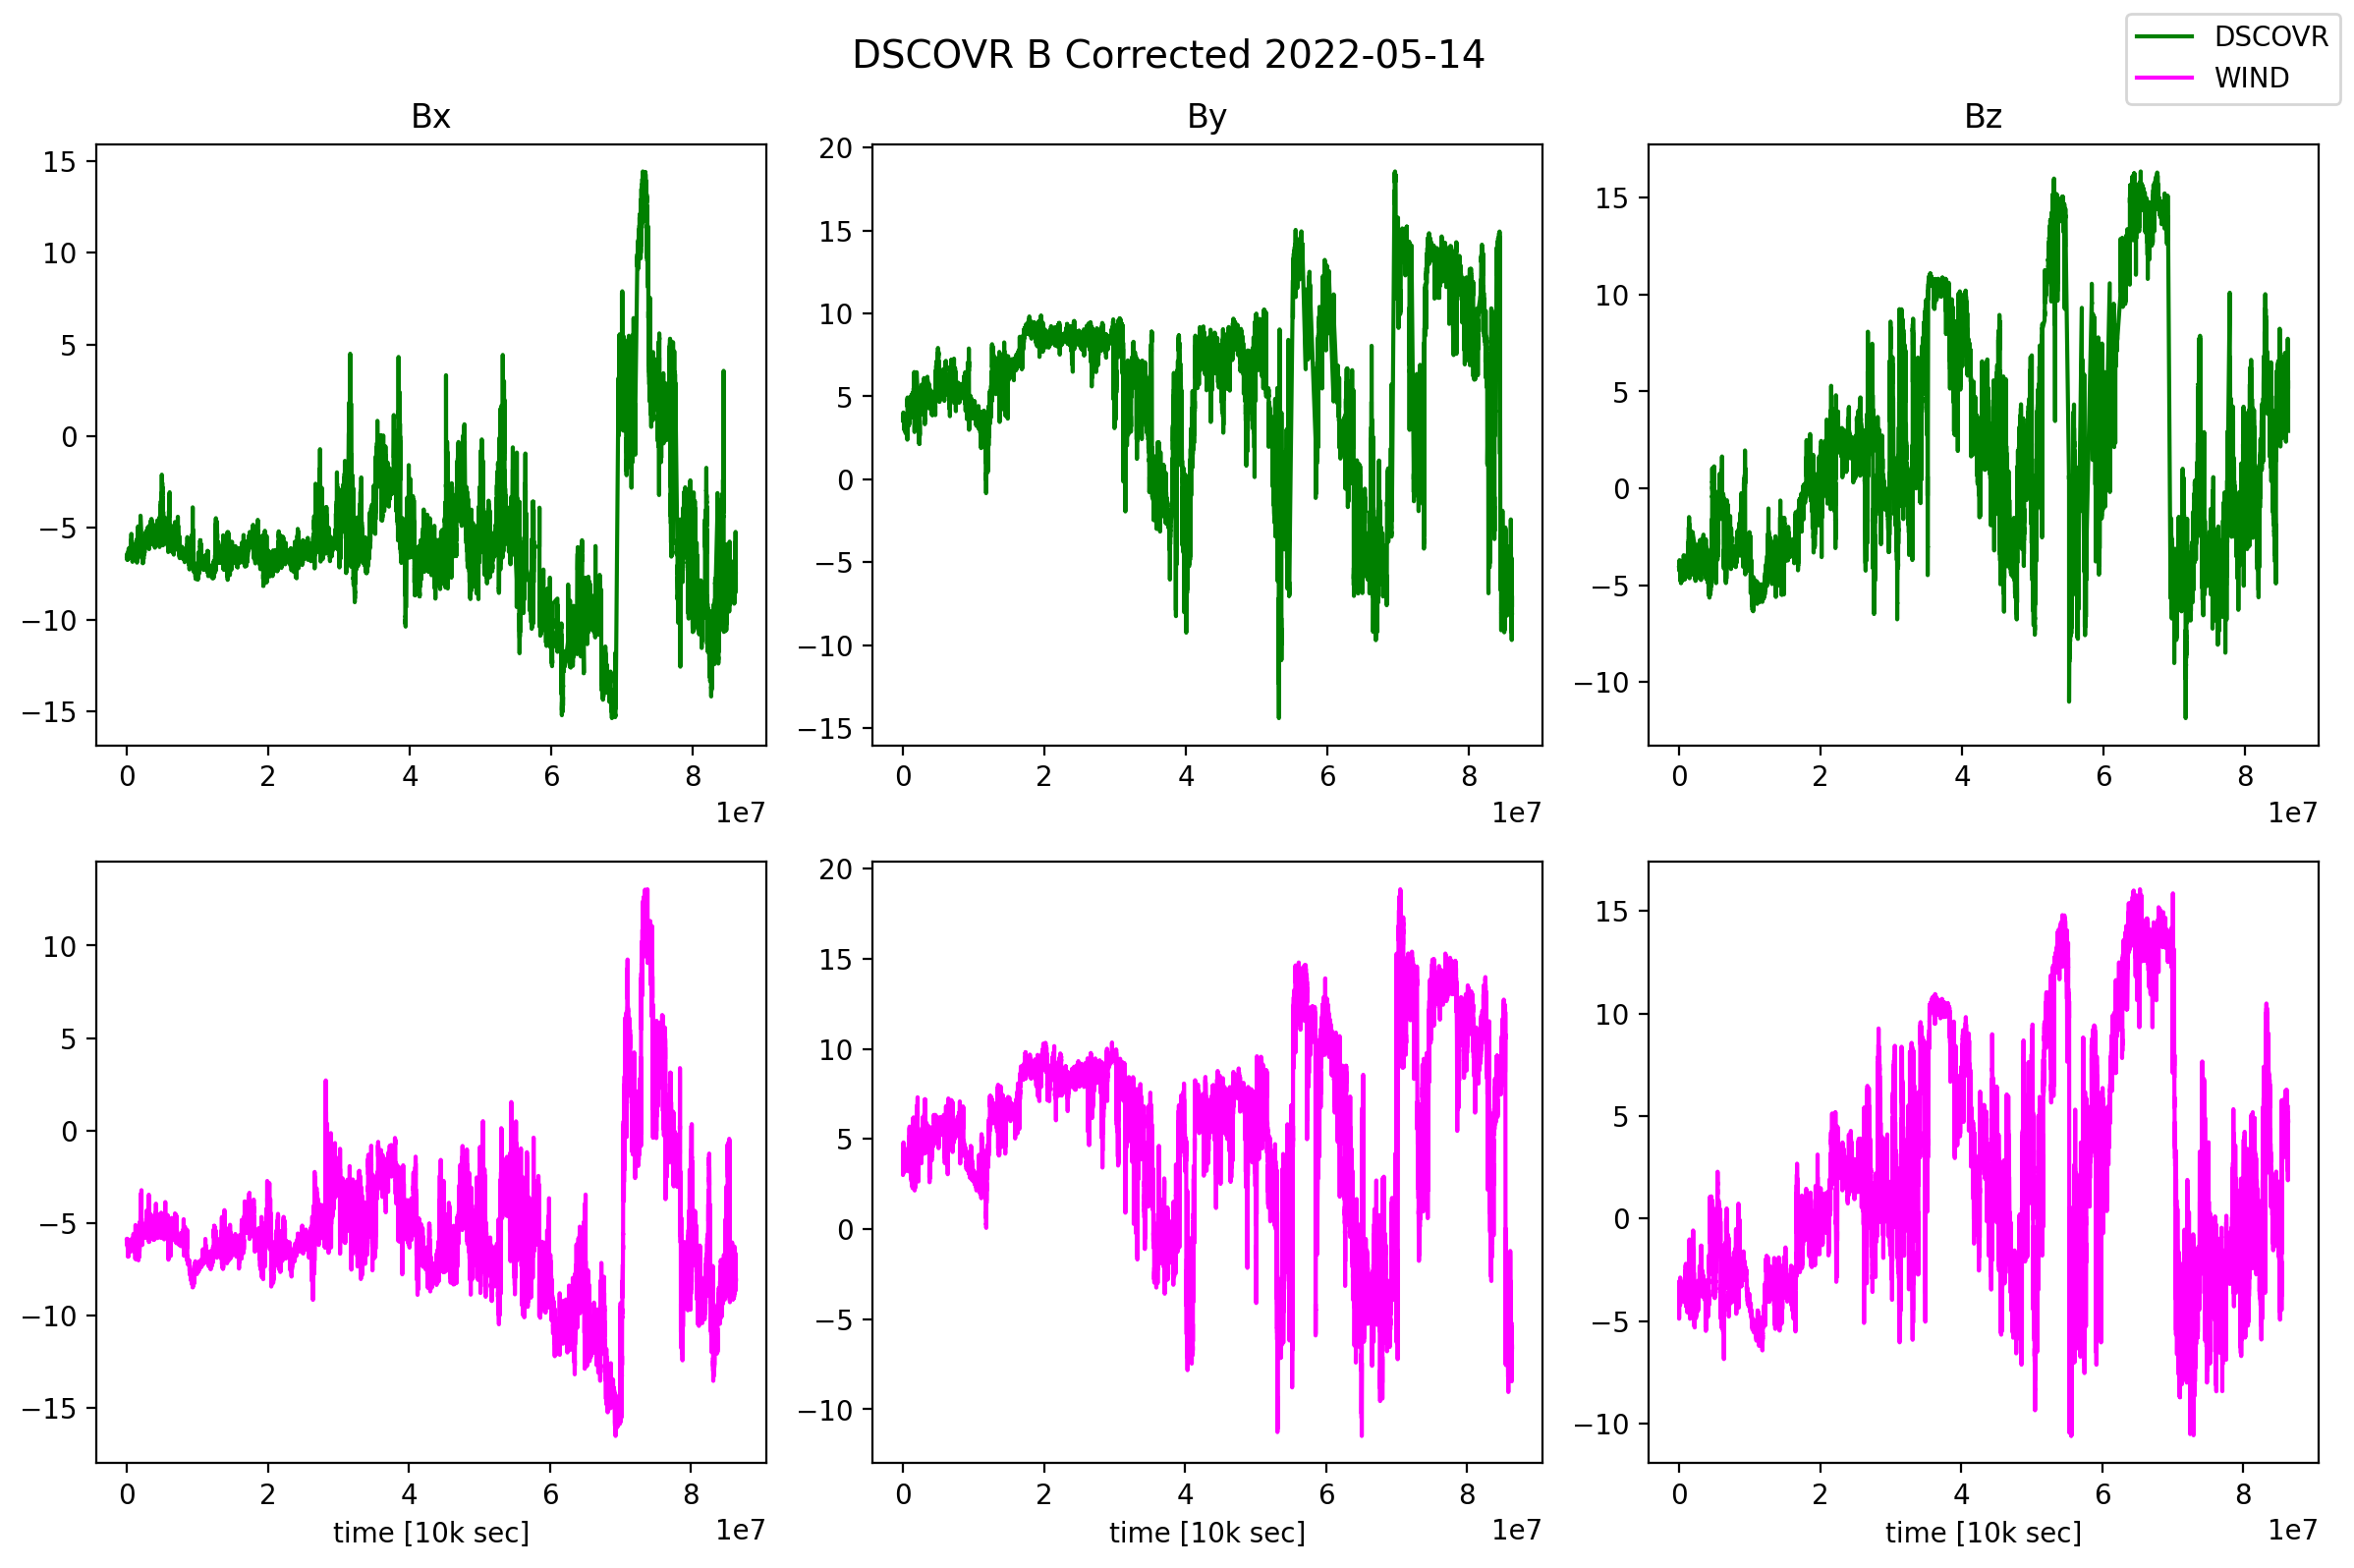

In [87]:
fig, axs = plt.subplots(2, 3)
title = 'DSCOVR B Corrected 2022-05-14'
fig.suptitle(title, fontsize=14)

d_t = np.asarray(dsc_t[:,:])
d_b = np.asarray(dsc_B[:,:])
g_t = d_t[good_data_indices]
g_b = d_b[good_data_indices]

d_bx, = axs[0,0].plot(g_t[:,2], g_b[:,0], color=dsc_colour, label='Bx')
d_by, = axs[0,1].plot(g_t[:,2], g_b[:,1], color=dsc_colour, label='By')
d_bz, = axs[0,2].plot(g_t[:,2], g_b[:,2], color=dsc_colour, label='Bz')

axs[0, 0].set(title='Bx')
axs[0, 1].set(title='By')
axs[0, 2].set(title='Bz')

axs[1, 0].set(xlabel='time [10k sec]')
axs[1, 1].set(xlabel='time [10k sec]')
axs[1, 2].set(xlabel='time [10k sec]')

w_t = np.asarray(wnd_t[:,:])
w_b = np.asarray(wnd_B[:,:])

w_bx, = axs[1,0].plot(w_t[wnd_t_ix,2], w_b[wnd_t_ix,0], color=wnd_colour, label='Bx')
w_by, = axs[1,1].plot(w_t[wnd_t_ix,2], w_b[wnd_t_ix,1], color=wnd_colour, label='By')
w_bz, = axs[1,2].plot(w_t[wnd_t_ix,2], w_b[wnd_t_ix,2], color=wnd_colour, label='Bz')

fig.legend([d_bx, w_bx], ['DSCOVR', 'WIND'], loc='upper right')

plt.tight_layout()

# Compare Corrected DSCOVR and WIND magnetic field vectors
We stack plots of Bx, By and Bz in the following cells.

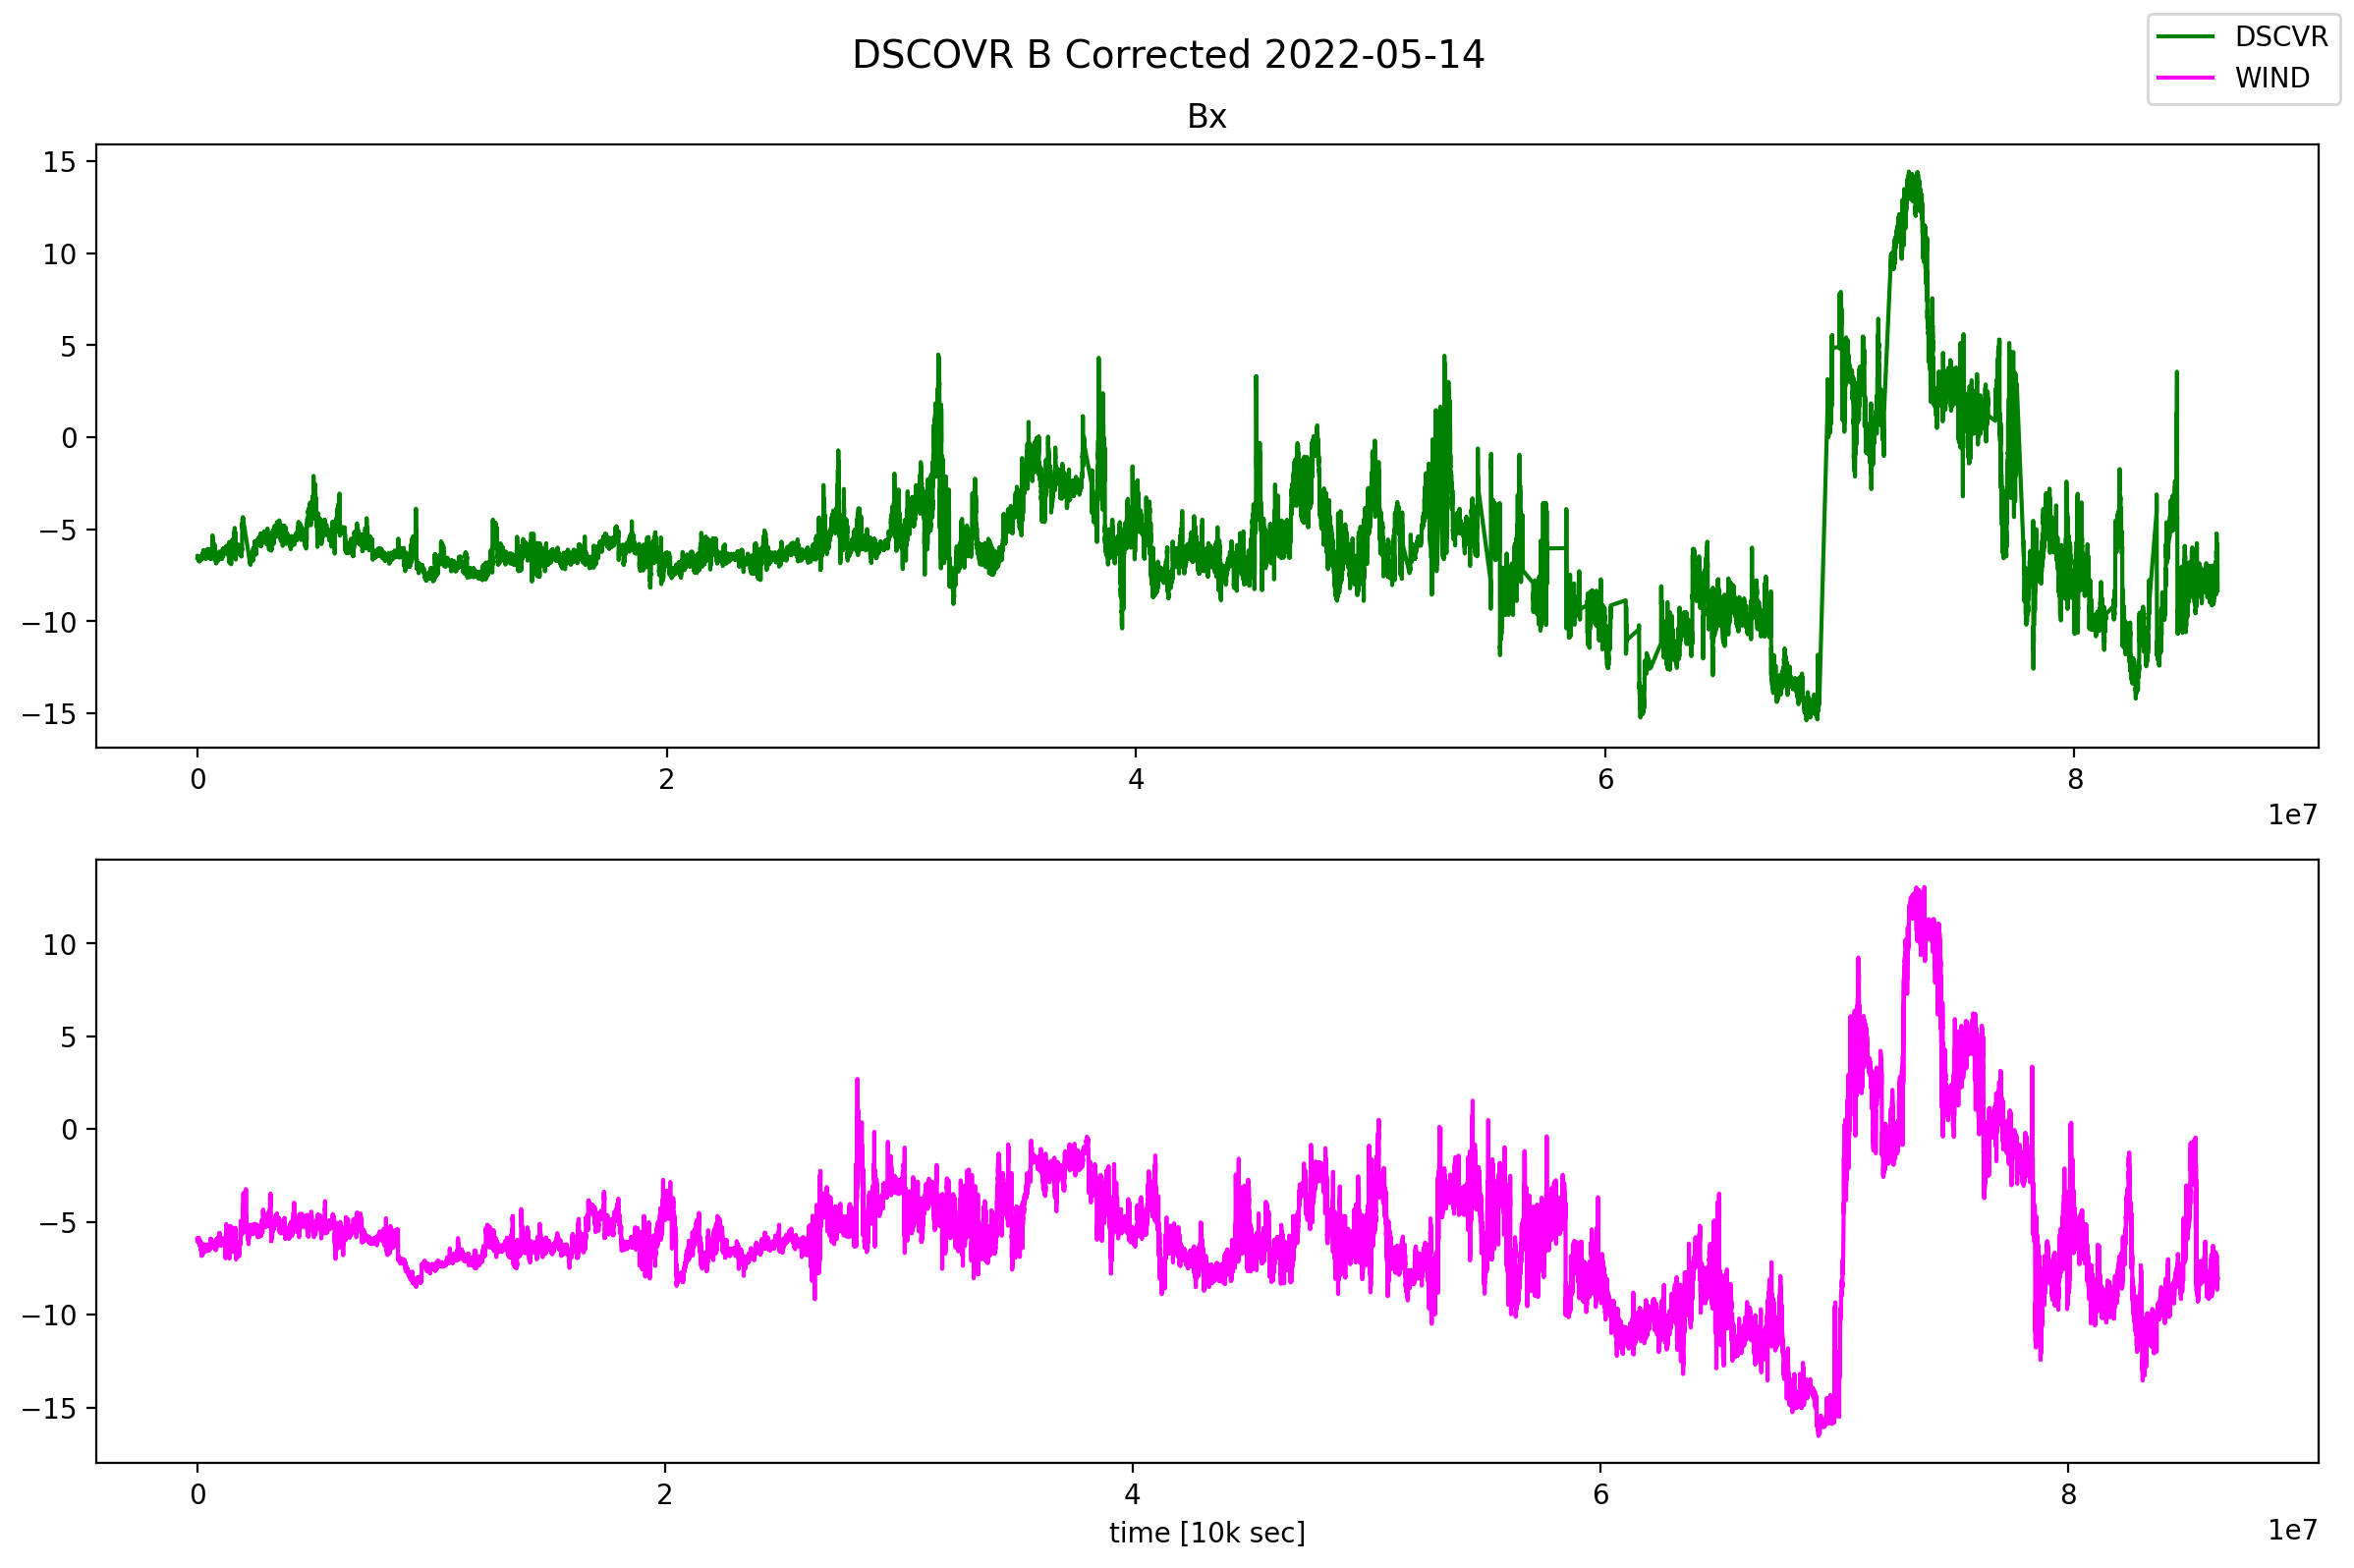

In [53]:
fig, axs = plt.subplots(2, 1)
title = 'DSCOVR B Corrected 2022-05-14'
fig.suptitle(title, fontsize=14)

d_bx, = axs[0].plot(g_t[:,2], g_b[:,0], color=dsc_colour, label='Bx')

axs[0].set(title='Bx')
axs[1].set(xlabel='time [10k sec]')

w_bx, = axs[1].plot(w_t[wnd_t_ix,2], w_b[wnd_t_ix,0], color=wnd_colour, label='Bx')

fig.legend([d_bx, w_bx], ['DSCOVR', 'WIND'], loc='upper right')

plt.tight_layout()

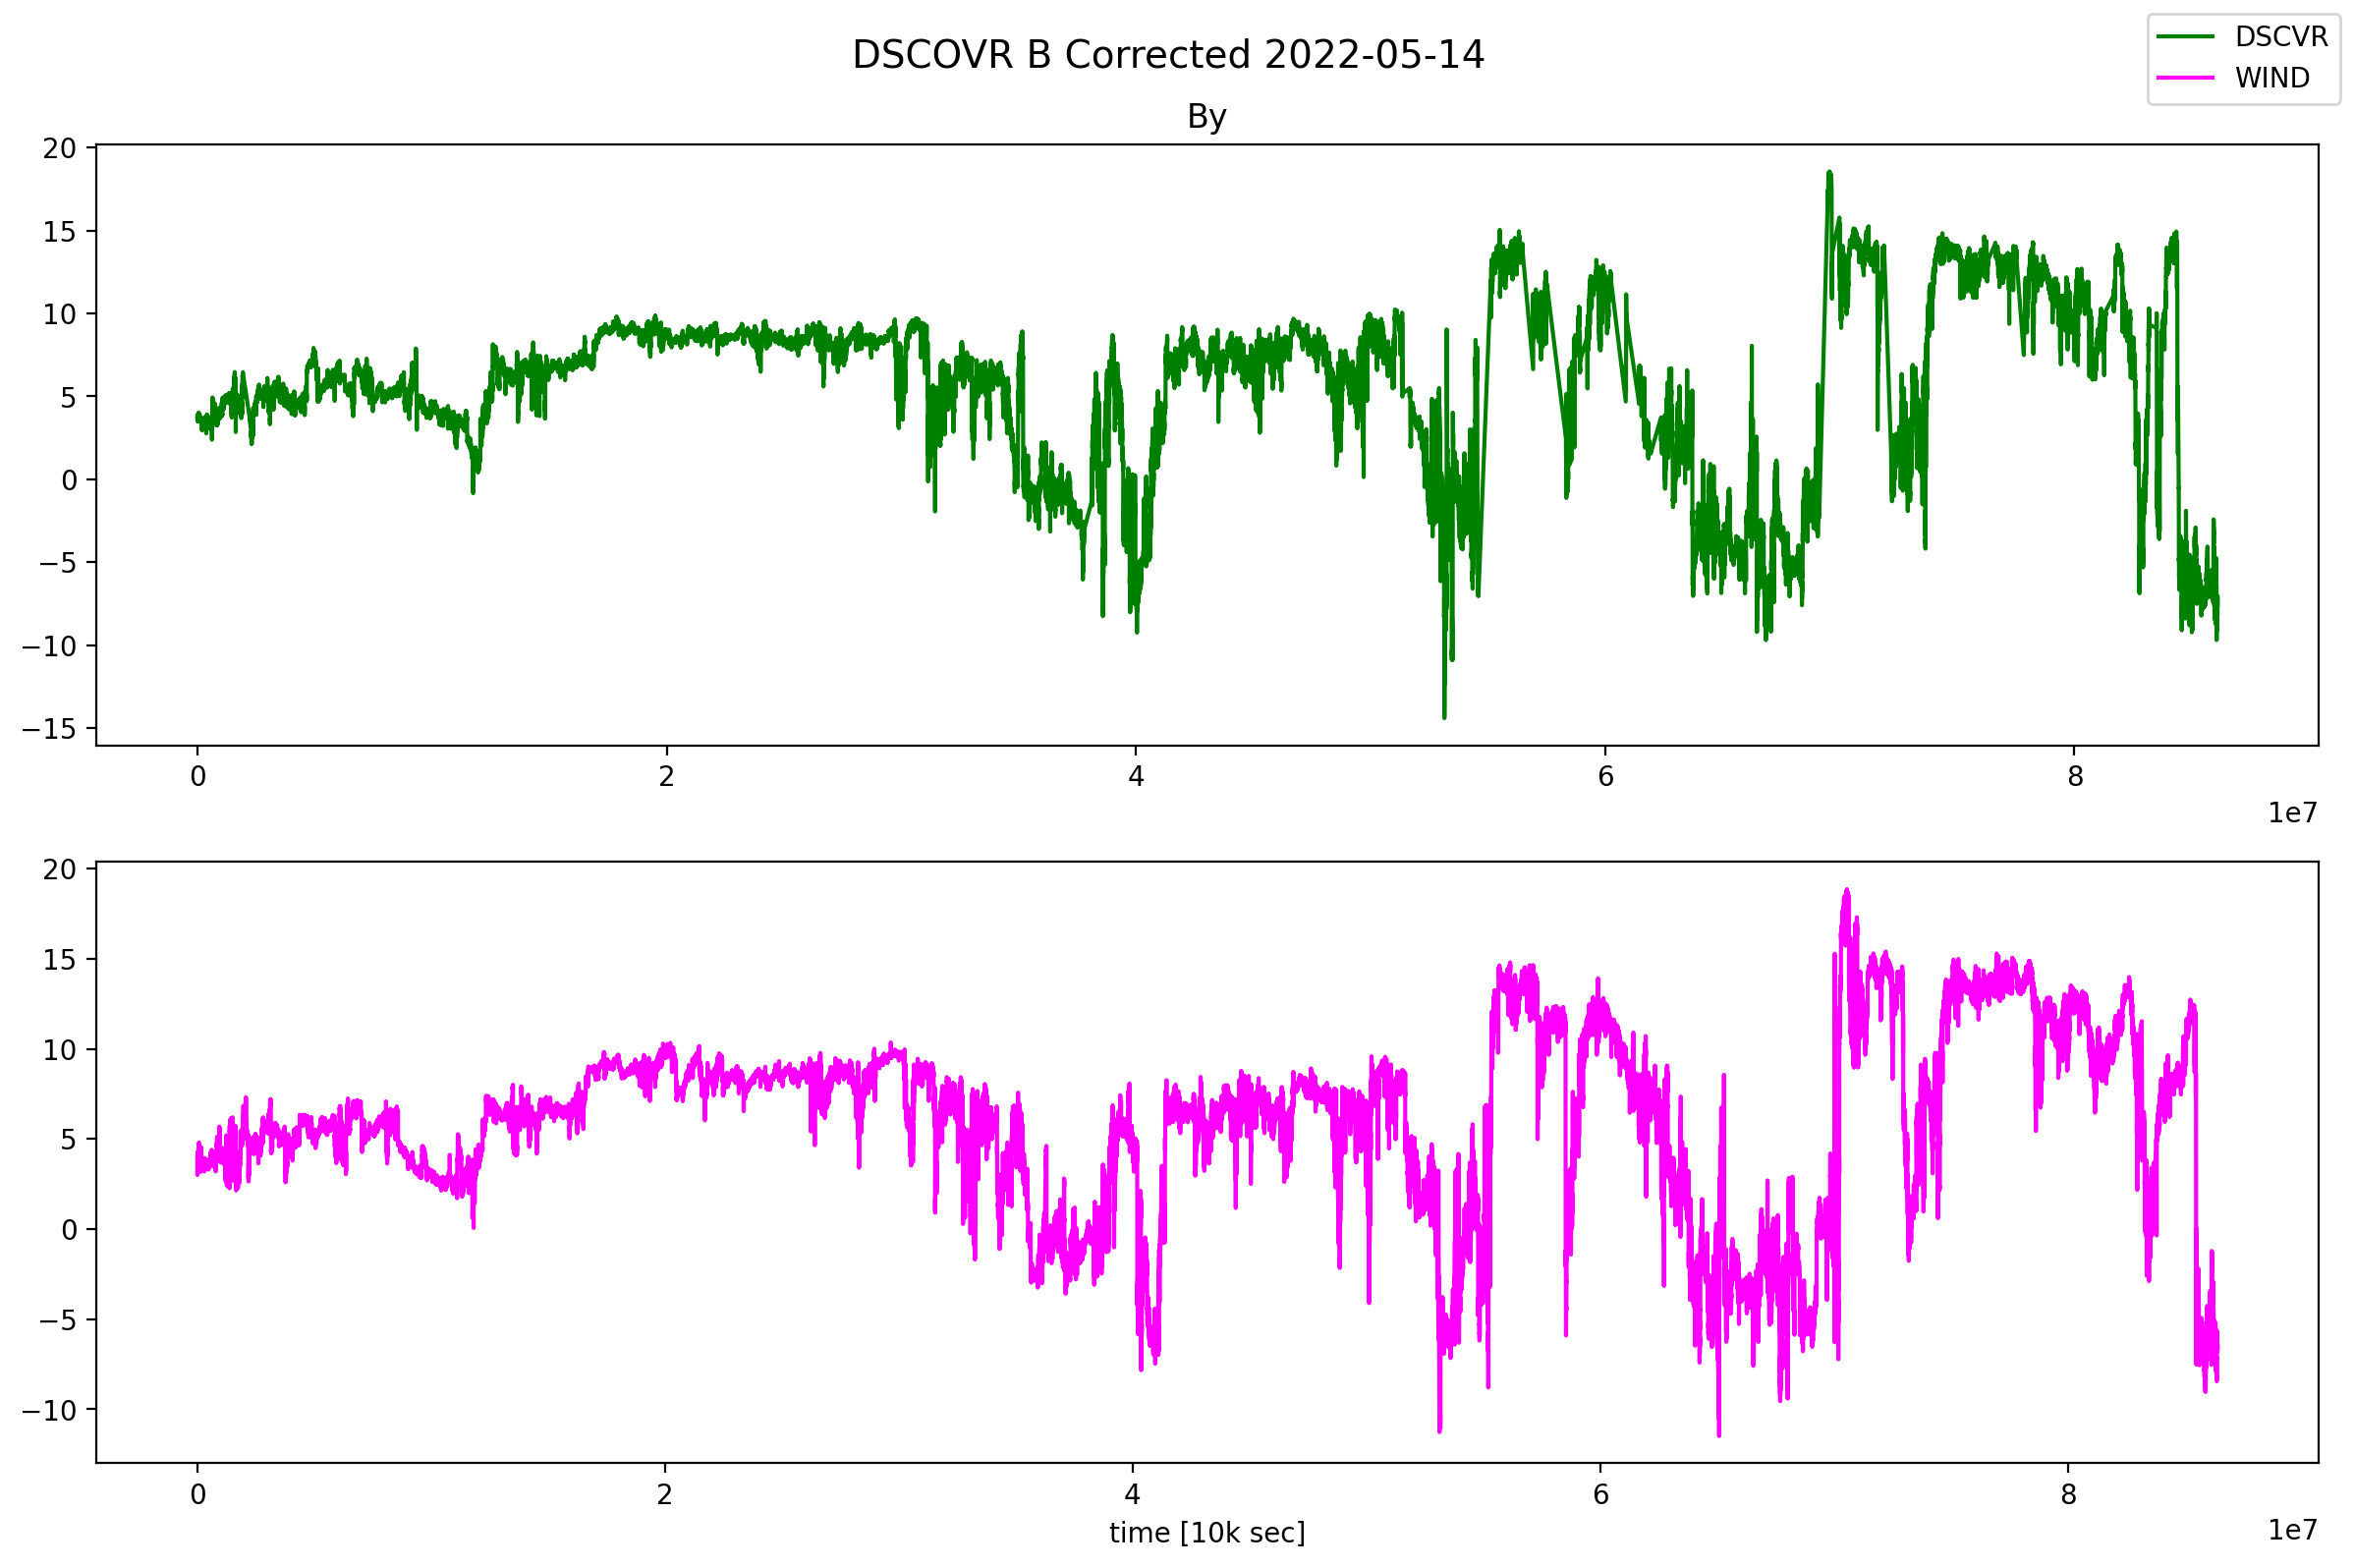

In [54]:
fig, axs = plt.subplots(2, 1)
title = 'DSCOVR B Corrected 2022-05-14'
fig.suptitle(title, fontsize=14)

d_by, = axs[0].plot(g_t[:,2], g_b[:,1], color=dsc_colour, label='By')

axs[0].set(title='By')
axs[1].set(xlabel='time [10k sec]')

w_by, = axs[1].plot(w_t[wnd_t_ix,2], w_b[wnd_t_ix,1], color=wnd_colour, label='By')

fig.legend([d_bx, w_bx], ['DSCOVR', 'WIND'], loc='upper right')

plt.tight_layout()

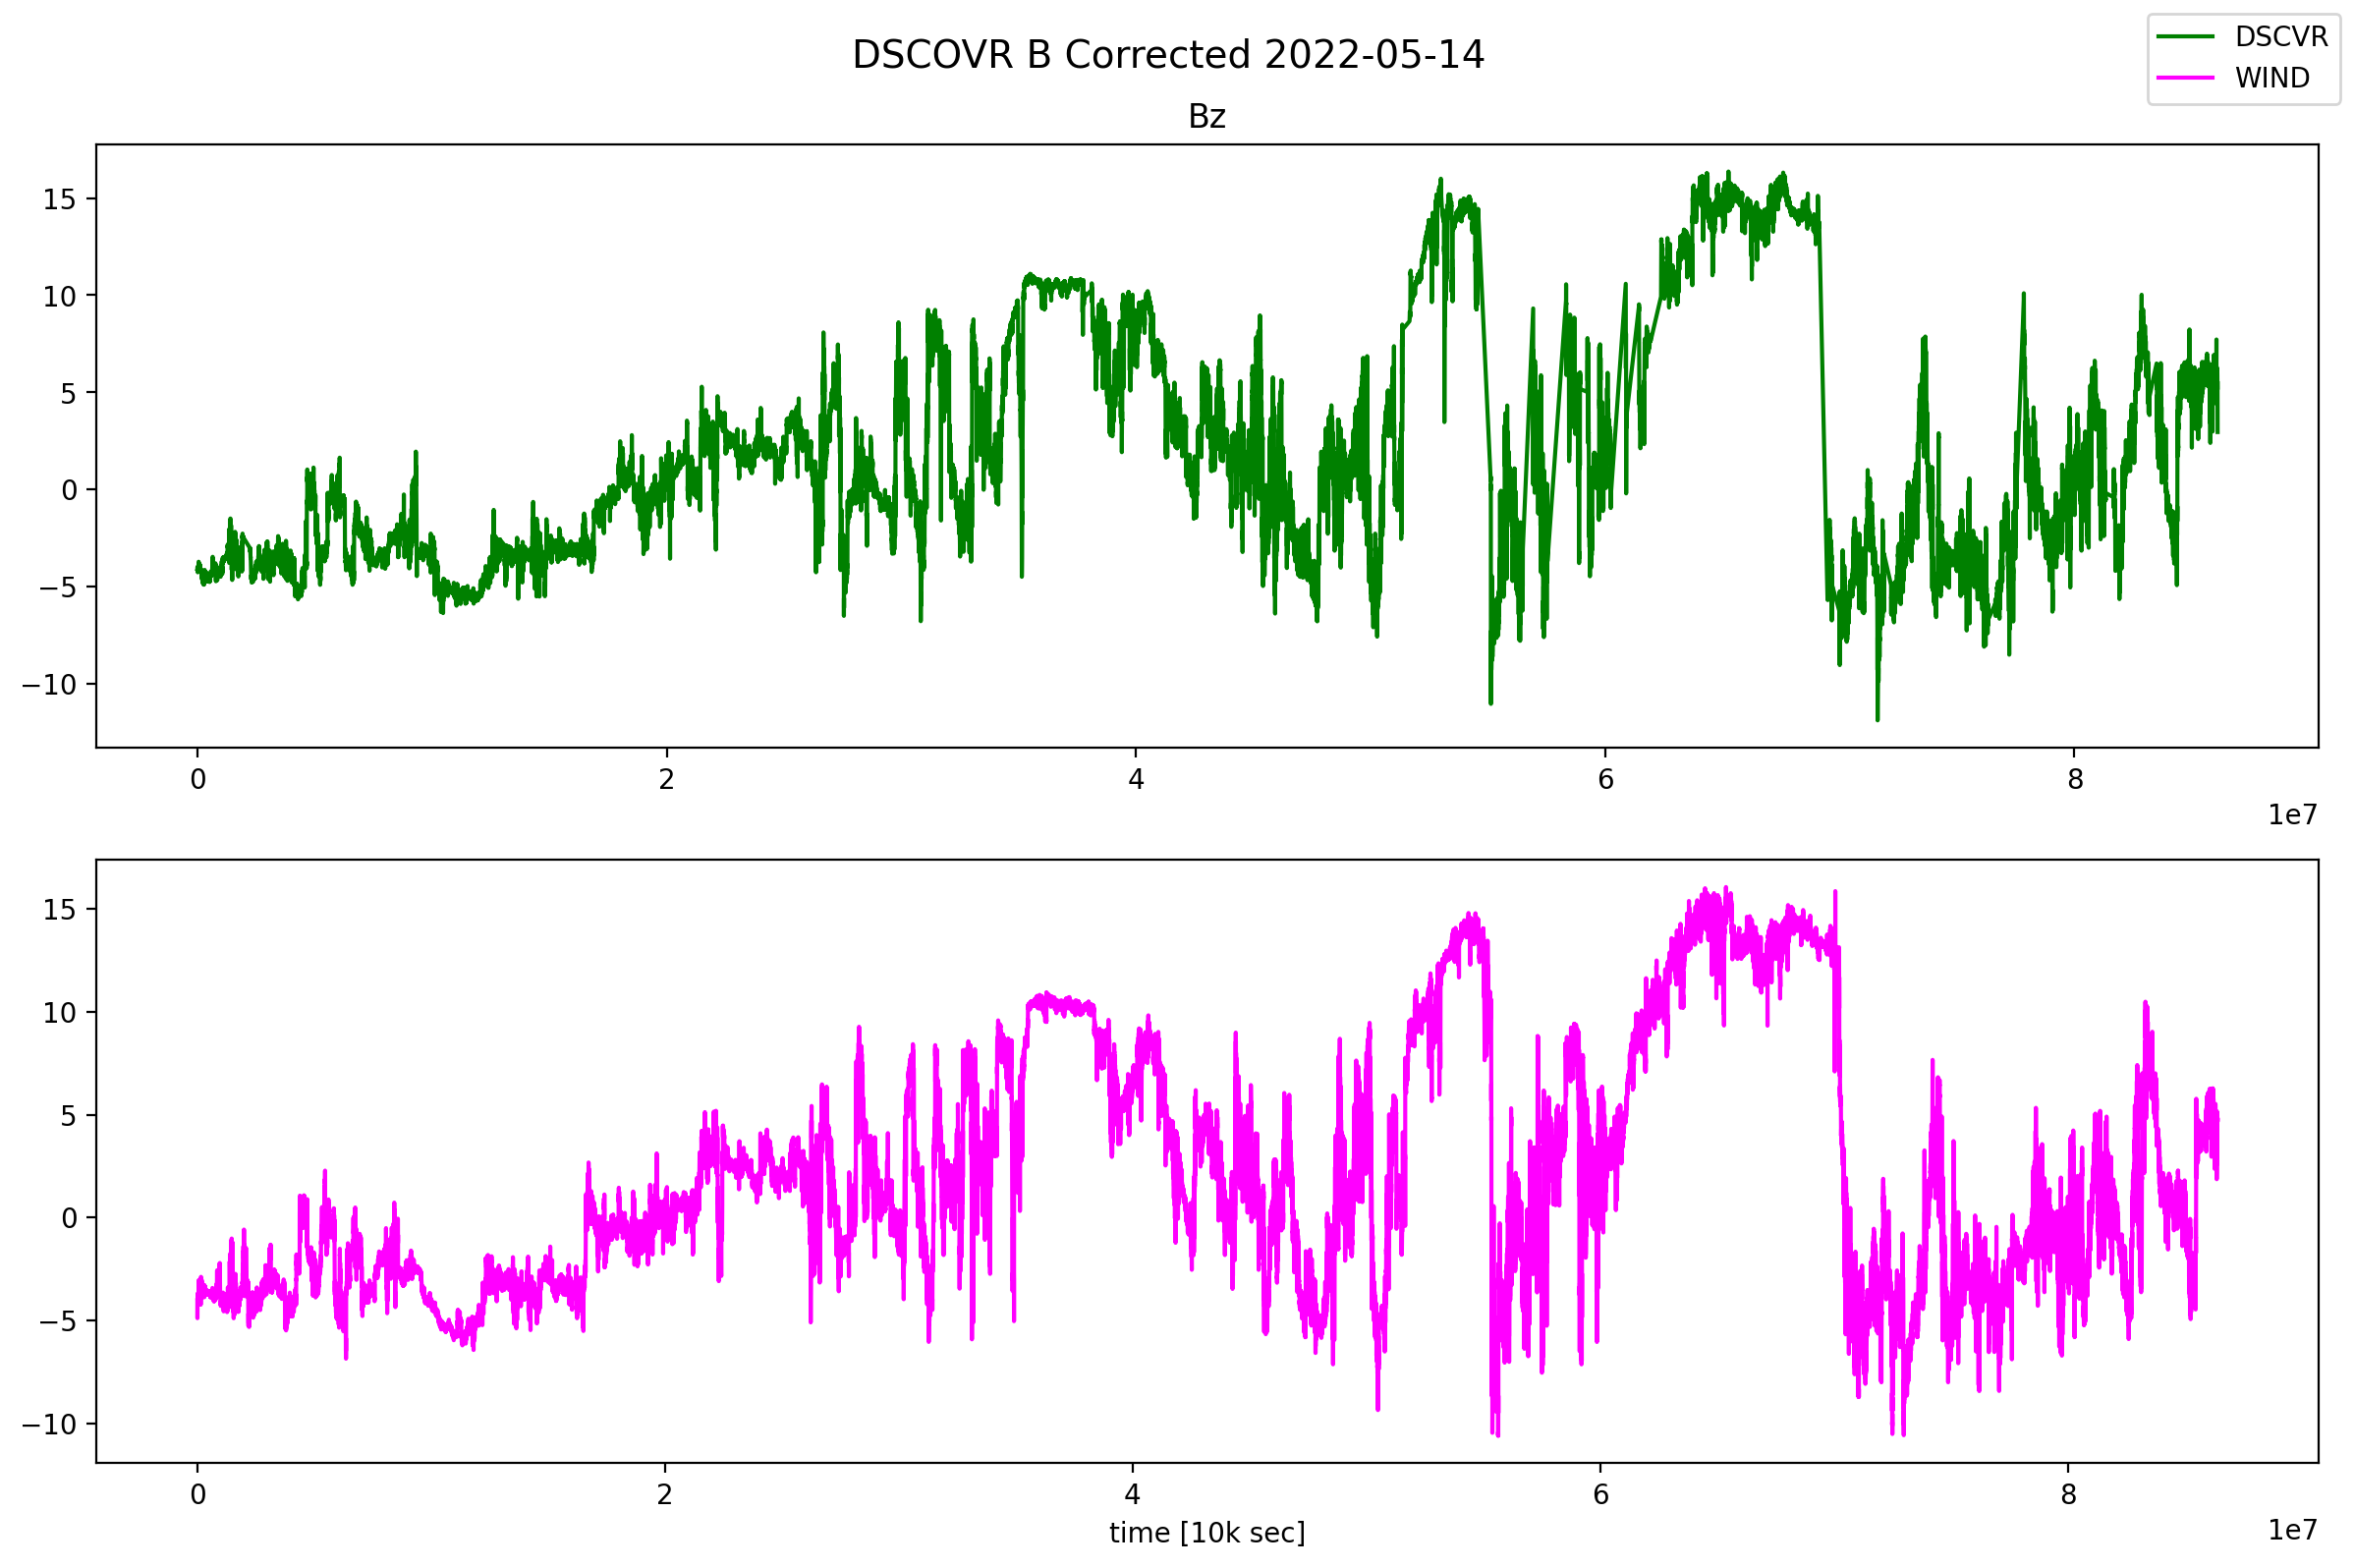

In [50]:
fig, axs = plt.subplots(2, 1)
title = 'DSCOVR B Corrected 2022-05-14'
fig.suptitle(title, fontsize=14)

d_bz, = axs[0].plot(g_t[:,2], g_b[:,2], color=dsc_colour, label='Bz')

axs[0].set(title='Bz')
axs[1].set(xlabel='time [10k sec]')

w_bz, = axs[1].plot(w_t[wnd_t_ix,2], w_b[wnd_t_ix,2], color=wnd_colour, label='Bz')

fig.legend([d_bx, w_bx], ['DSCOVR', 'WIND'], loc='upper right')

plt.tight_layout()